# Exploratory Data Analysis on Google Play Store Apps

For this EDA, we will be using the `googleplaystore` dataset and `googleplaystore_user_reviews` dataset. These datasets contain the Google Play Store Apps, and each app (row) has values for catergory, rating, size, and more. The goal of this EDA is to discover patterns and outliers while also creating a hypothesis based on our understanding of the dataset.
\
\
Dataset Source: https://www.kaggle.com/datasets/lava18/google-play-store-apps?select=googleplaystore.csv
\
\
SLT Number: 11 
\
LT Members: Banquerigo, Del Carmen, Menorca, Yepes

# Key Business Questions

1. What’s the most downloaded app?
2. What’s the most popular app genre?
3. What’s the lowest/highest-rated app?
4. Does price affect app popularity?
5. Does content rating affect app popularity?
6. Is number of installs correlated with reviews or ratings?
7. Potential profit of an app based on number of installs?
8. Does app size affect number of installs, reviews, or ratings?
9. Does last app update affect the reviews, ratings, or popularity?
10. Is sentiment related to the app reviews, ratings, or popularity?



# Importing Libaries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from io import StringIO
from  matplotlib.ticker import PercentFormatter
from pandas_profiling import ProfileReport
from dateutil.parser import parse

# Custom plot format
plt.rcParams['figure.figsize'] = 16,6
plt.rcParams['lines.linewidth'] = 3.5
plt.rcParams['figure.titlesize'] = 32

custom_sns_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme('notebook', style='ticks', font_scale=1.5, rc=custom_sns_params)
colors = ['#393357', '#FFD400', '#00A5D3', '#009A57', '#6E3476']
custom_palette = sns.blend_palette(colors, n_colors=8)
sns.set_palette(custom_palette)

def get_outliers(df, cat, lim_range=1.5):
    """
    Reference: https://www.askpython.com/python/examples/detection-removal-outliers-in-python
    """
    # IQR METHOD: within 1.5 IQR
    q25, q75 = df[cat].quantile(0.25), df[cat].quantile(0.75)
    iqr = q75 - q25 
    # calculate the outlier cutoff
    cut_off = iqr * lim_range
    lower, upper = q25 - cut_off, q75 + cut_off
    print(f'IQR: {iqr} -- Lower: {lower} -- Upper: {upper}')
    return lower, upper

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-udewiib3 because the default path (/home/byepes/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


# Reading The Data

## `googleplaystore.csv`

In [2]:
df = pd.read_csv('googleplaystore.csv')
df.head()

App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend Play  January 15, 2018               2.0.0   
2               Art & Design    August 1, 2018               1.2.4   
3               Art & Design      June 8, 2018  Varies with device   
4    Art & Design;Creativity     June 20, 2018                 1.1   

    Android Ver  
0  4.0.3 and up  
1  4.0.3 and up  
2  4.0.3 and up  
3    4.2 and up  
4    4.4 and up

# `googleplaystore_user_reviews.csv`

In [3]:
df_review = pd.read_csv('googleplaystore_user_reviews.csv')
df_review.head()

App                                  Translated_Review  \
0  10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1  10 Best Foods for You    This help eating healthy exercise regular basis   
2  10 Best Foods for You                                                NaN   
3  10 Best Foods for You         Works great especially going grocery store   
4  10 Best Foods for You                                       Best idea us   

  Sentiment  Sentiment_Polarity  Sentiment_Subjectivity  
0  Positive                1.00                0.533333  
1  Positive                0.25                0.288462  
2       NaN                 NaN                     NaN  
3  Positive                0.40                0.875000  
4  Positive                1.00                0.300000

# Dropping Columns

We will be dropping the columns `Current Ver` and `Android Ver` since we will not be needing those columns for our insights.

In [4]:
df = df.drop(df[['Current Ver', 'Android Ver']], axis=1)
df.head()

App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated  
0               Art & Design   January 7, 2018  
1  Art & Design;Pretend Play  January 15, 2018  
2               Art & Design    August 1, 2018  
3               Art & Design      June 8, 2018  
4    Art & Design;Creativity     June 20, 2018

# Merging Columns

Since we need both datasets for our insights, we will be merging `googleplaystore.csv` and `googleplaystore_user_reviews.csv` together. We can do this by using `pandas.DataFrame.merge`.

In [5]:
# Delete this after finishing. No need to merge

# Missing Value Imputation

In [6]:
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
dtype: int64

As observed, the dataset is not clean and we therefore have to impute values to columns with NaN or null values. We have `1,474` NaN values for `Rating` column. We will impute missing values based on the mean of `Category` per `Type`.

Before we can do that, we first have to handle the missing values for `Type` column and `Content Rating` column by deleting those entries.

In [7]:
df = df[df['Type'].notna()]
df = df[df['Content Rating'].notna()]

In [8]:
df.isnull().sum()

App                  0
Category             0
Rating            1473
Reviews              0
Size                 0
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
Last Updated         0
dtype: int64

Now that only the `Rating` column has null values, we will impute missing values based on the mean of `Category` per `Type`. Instead of using `groupby` we will implement a for loop to do the conditional changes.

In [9]:
category_list = df['Category'].unique().tolist()
type_list = df['Type'].unique().tolist()

for i in type_list:
    for j in category_list:
        mean = df.loc[(df['Category'] == j) &
                      (df['Type'] == i)]['Rating'].mean(skipna=True)
        df.loc[(df['Category'] == j) &
               (df['Type'] == i) &
               (df['Rating'].isna()), 'Rating'] = mean

In [10]:
df.isna().sum()

App               0
Category          0
Rating            2
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
dtype: int64

In [11]:
df.loc[df['Rating'].isna()]

App            Category  Rating Reviews  Size  \
6567  Socle Commun BO du 23-04-2015  LIBRARIES_AND_DEMO     NaN       4  4.7M   
6624        BP Fitness Lead Scanner              EVENTS     NaN       0  6.7M   

     Installs  Type    Price Content Rating            Genres     Last Updated  
6567     100+  Paid    $0.99       Everyone  Libraries & Demo   August 8, 2016  
6624       1+  Paid  $109.99       Everyone            Events  August 23, 2017

Based on the results above, we still have 2 entries with null `Rating` values. Both entries remained as null values since they're the sole entries on their corresponding `Category`-`Type` pair filter. We will be deleting these values because we do not want to impute its values with the mean rating of its `Free` counterpart.

In [12]:
df = df[df['Rating'].notna()]
df['Rating'] = df['Rating'].round(decimals=2)

In [13]:
df.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
dtype: int64

# Adding columns

Some entries of `Genres` column have two (2) entries separated by a semicolon `;`. We will split this column into its `Genre Main` and `Genre Sub` counterpart while retaining the original column.

In [14]:
df[['Genre Main', 'Genre Sub']] = df['Genres'].str.split(';', expand=True)
df = df.fillna('None')
df.tail()

App             Category  \
10836                               Sya9a Maroc - FR               FAMILY   
10837               Fr. Mike Schmitz Audio Teachings               FAMILY   
10838                         Parkinson Exercices FR              MEDICAL   
10839                  The SCP Foundation DB fr nn5n  BOOKS_AND_REFERENCE   
10840  iHoroscope - 2018 Daily Horoscope & Astrology            LIFESTYLE   

       Rating Reviews                Size     Installs  Type Price  \
10836    4.50      38                 53M       5,000+  Free     0   
10837    5.00       4                3.6M         100+  Free     0   
10838    4.17       3                9.5M       1,000+  Free     0   
10839    4.50     114  Varies with device       1,000+  Free     0   
10840    4.50  398307                 19M  10,000,000+  Free     0   

      Content Rating             Genres      Last Updated         Genre Main  \
10836       Everyone          Education     July 25, 2017          Education   
10837       Everyone          Education      July 6, 2018          Education   
10838       Everyone            Medical  January 20, 2017            Medical   
10839     Mature 17+  Books & Reference  January 19, 2015  Books & Reference   
10840       Everyone          Lifestyle     July 25, 2018          Lifestyle   

      Genre Sub  
10836      None  
10837      None  
10838      None  
10839      None  
10840      None

# Fixing Datatypes

Currently, our datatypes are not in order (e.g. `Size` column is in string instead of `float` in MB). We need to change datatypes per column to the following:

1. `App` - String
2. `Category` - String
3. `Rating` - Float rounded off to 2 decimal places
4. `Reviews` - Integer
5. `Size` - Float in MB
6. `Installs` - String
7. `Type` - String
8. `Price` - Float in Dollars
9. `Content Rating` - String
10. `Genres` - String
11. `Last Updated` - Datetime
12. `Genre Main` - String
13. `Genre Sub` - String

In [15]:
#df.loc[df['Size'] == 'Varies with device']
df

App             Category  \
0         Photo Editor & Candy Camera & Grid & ScrapBook       ART_AND_DESIGN   
1                                    Coloring book moana       ART_AND_DESIGN   
2      U Launcher Lite – FREE Live Cool Themes, Hide ...       ART_AND_DESIGN   
3                                  Sketch - Draw & Paint       ART_AND_DESIGN   
4                  Pixel Draw - Number Art Coloring Book       ART_AND_DESIGN   
...                                                  ...                  ...   
10836                                   Sya9a Maroc - FR               FAMILY   
10837                   Fr. Mike Schmitz Audio Teachings               FAMILY   
10838                             Parkinson Exercices FR              MEDICAL   
10839                      The SCP Foundation DB fr nn5n  BOOKS_AND_REFERENCE   
10840      iHoroscope - 2018 Daily Horoscope & Astrology            LIFESTYLE   

       Rating Reviews                Size     Installs  Type Price  \
0        4.10     159                 19M      10,000+  Free     0   
1        3.90     967                 14M     500,000+  Free     0   
2        4.70   87510                8.7M   5,000,000+  Free     0   
3        4.50  215644                 25M  50,000,000+  Free     0   
4        4.30     967                2.8M     100,000+  Free     0   
...       ...     ...                 ...          ...   ...   ...   
10836    4.50      38                 53M       5,000+  Free     0   
10837    5.00       4                3.6M         100+  Free     0   
10838    4.17       3                9.5M       1,000+  Free     0   
10839    4.50     114  Varies with device       1,000+  Free     0   
10840    4.50  398307                 19M  10,000,000+  Free     0   

      Content Rating                     Genres      Last Updated  \
0           Everyone               Art & Design   January 7, 2018   
1           Everyone  Art & Design;Pretend Play  January 15, 2018   
2           Everyone               Art & Design    August 1, 2018   
3               Teen               Art & Design      June 8, 2018   
4           Everyone    Art & Design;Creativity     June 20, 2018   
...              ...                        ...               ...   
10836       Everyone                  Education     July 25, 2017   
10837       Everyone                  Education      July 6, 2018   
10838       Everyone                    Medical  January 20, 2017   
10839     Mature 17+          Books & Reference  January 19, 2015   
10840       Everyone                  Lifestyle     July 25, 2018   

              Genre Main     Genre Sub  
0           Art & Design          None  
1           Art & Design  Pretend Play  
2           Art & Design          None  
3           Art & Design          None  
4           Art & Design    Creativity  
...                  ...           ...  
10836          Education          None  
10837          Education          None  
10838            Medical          None  
10839  Books & Reference          None  
10840          Lifestyle          None  

[10837 rows x 13 columns]

## `Size` to Float in MB

Initially, the `Size` column contains string values showing three unit types namely: M, k, and 'Varies with device'. We need to convert everything such that there is uniformity in units of measurement. For the 'Varies with device' values, we will treat then as NaN or null values and we will be imputing values based of the mean rating of `Category` per `Type`.

In [16]:
df['size_code']=df['Size'].str[-1:]
df['size_number']=df['Size'].str[0:-1]
df['size_number']=df['size_number'].replace('Varies with devic',np.nan)
df['size_number']=df['size_number'].astype(float)

In [17]:
conditions = [(df['size_code'] == 'k'), (df['size_code'] == 'M'), (df['size_code'] == 'e')]
choices = [df['size_number']/1024, df['size_number'], np.nan]
df['Size in MB'] = np.select(conditions, choices, default=np.nan)
df = df.drop(df[['size_code', 'size_number', 'Size']], axis=1)
df.head()

App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews     Installs  Type Price Content Rating                     Genres  \
0     159      10,000+  Free     0       Everyone               Art & Design   
1     967     500,000+  Free     0       Everyone  Art & Design;Pretend Play   
2   87510   5,000,000+  Free     0       Everyone               Art & Design   
3  215644  50,000,000+  Free     0           Teen               Art & Design   
4     967     100,000+  Free     0       Everyone    Art & Design;Creativity   

       Last Updated    Genre Main     Genre Sub  Size in MB  
0   January 7, 2018  Art & Design          None        19.0  
1  January 15, 2018  Art & Design  Pretend Play        14.0  
2    August 1, 2018  Art & Design          None         8.7  
3      June 8, 2018  Art & Design          None        25.0  
4     June 20, 2018  Art & Design    Creativity         2.8

In [18]:
category_list = df['Category'].unique().tolist()
type_list = df['Type'].unique().tolist()

for i in type_list:
    for j in category_list:
        mean = df.loc[(df['Category'] == j) &
                      (df['Type'] == i)]['Size in MB'].mean(skipna=True)
        df.loc[(df['Category'] == j) &
               (df['Type'] == i) &
               (df['Size in MB'].isna()), 'Size in MB'] = mean
df['Size in MB'] = df['Size in MB'].round(decimals=2)

In [19]:
df.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Genre Main        0
Genre Sub         0
Size in MB        0
dtype: int64

## `Last Updated` to datetime

In [20]:
df['Last Updated'] = df['Last Updated'].apply(lambda x: parse(x))
df.head()

App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews     Installs  Type Price Content Rating                     Genres  \
0     159      10,000+  Free     0       Everyone               Art & Design   
1     967     500,000+  Free     0       Everyone  Art & Design;Pretend Play   
2   87510   5,000,000+  Free     0       Everyone               Art & Design   
3  215644  50,000,000+  Free     0           Teen               Art & Design   
4     967     100,000+  Free     0       Everyone    Art & Design;Creativity   

  Last Updated    Genre Main     Genre Sub  Size in MB  
0   2018-01-07  Art & Design          None        19.0  
1   2018-01-15  Art & Design  Pretend Play        14.0  
2   2018-08-01  Art & Design          None         8.7  
3   2018-06-08  Art & Design          None        25.0  
4   2018-06-20  Art & Design    Creativity         2.8

## `Price` to `Price in Dollars`

In [21]:
df['Price'] = df['Price'].str.replace('$', '').astype('float')
df.head()

/tmp/ipykernel_597/3436614008.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '').astype('float')


App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews     Installs  Type  Price Content Rating                     Genres  \
0     159      10,000+  Free    0.0       Everyone               Art & Design   
1     967     500,000+  Free    0.0       Everyone  Art & Design;Pretend Play   
2   87510   5,000,000+  Free    0.0       Everyone               Art & Design   
3  215644  50,000,000+  Free    0.0           Teen               Art & Design   
4     967     100,000+  Free    0.0       Everyone    Art & Design;Creativity   

  Last Updated    Genre Main     Genre Sub  Size in MB  
0   2018-01-07  Art & Design          None        19.0  
1   2018-01-15  Art & Design  Pretend Play        14.0  
2   2018-08-01  Art & Design          None         8.7  
3   2018-06-08  Art & Design          None        25.0  
4   2018-06-20  Art & Design    Creativity         2.8

## `Reviews` to integer

In [22]:
df['Reviews'] = df['Reviews'].astype('int')

# Standardizing App Name

In [23]:
data = df
data['App'] = data.App.str.strip().str.title() # since App name acts as the ID, this needs to be standardized and cleaned

In [24]:
unique_apps = data.App.unique()
unique_ids = [ [i, j] for i, j in enumerate(unique_apps) ]
df_app_master = pd.DataFrame(unique_ids, columns=['App_ID', 'App'])
data = (df_app_master.merge(data, on='App', how='left')
                     .sort_values(['App_ID', 'Last Updated'], ascending=[True, False])
                     .drop_duplicates('App_ID', keep='last')) # only the most recent updated ID was kept;
                                                              # this is to ensure that prices won't be overestimated
data['Installs_Min'] = data.Installs.str.replace(',', '').str.replace('+', '').astype(int)

/tmp/ipykernel_597/2396954293.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  data['Installs_Min'] = data.Installs.str.replace(',', '').str.replace('+', '').astype(int)


In [25]:
data.shape, df_app_master.shape, data.App.count(), data.App_ID.nunique()

((9635, 15), (9635, 2), 9635, 9635)

In [26]:
data.head()

App_ID                                                App        Category  \
0       0     Photo Editor & Candy Camera & Grid & Scrapbook  ART_AND_DESIGN   
2       1                                Coloring Book Moana          FAMILY   
3       2  U Launcher Lite – Free Live Cool Themes, Hide ...  ART_AND_DESIGN   
4       3                              Sketch - Draw & Paint  ART_AND_DESIGN   
5       4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN   

   Rating  Reviews     Installs  Type  Price Content Rating  \
0     4.1      159      10,000+  Free    0.0       Everyone   
2     3.9      974     500,000+  Free    0.0       Everyone   
3     4.7    87510   5,000,000+  Free    0.0       Everyone   
4     4.5   215644  50,000,000+  Free    0.0           Teen   
5     4.3      967     100,000+  Free    0.0       Everyone   

                      Genres Last Updated    Genre Main     Genre Sub  \
0               Art & Design   2018-01-07  Art & Design          None   
2  Art & Design;Pretend Play   2018-01-15  Art & Design  Pretend Play   
3               Art & Design   2018-08-01  Art & Design          None   
4               Art & Design   2018-06-08  Art & Design          None   
5    Art & Design;Creativity   2018-06-20  Art & Design    Creativity   

   Size in MB  Installs_Min  
0        19.0         10000  
2        14.0        500000  
3         8.7       5000000  
4        25.0      50000000  
5         2.8        100000

# Descriptive Statistics

We are left with `13 columns` for `googleplaystore` dataset. 

9 Dimensions - `App`, `Category`, `Installs`, `Type`, `Content Rating`, `Genres`, `Last Updated`, `Genre Main`,  and `Genre Sub`

4 Measures - `Rating`, `Reviews`, `Price`, and `Size in MB`



In [27]:
df.dtypes

App                       object
Category                  object
Rating                   float64
Reviews                    int64
Installs                  object
Type                      object
Price                    float64
Content Rating            object
Genres                    object
Last Updated      datetime64[ns]
Genre Main                object
Genre Sub                 object
Size in MB               float64
dtype: object

The `dataframe.describe()` function of pandas returns the `count`, `mean`, `std`, and `quartiles` of the measures column of the dataset by default. To include all values, you can use `dataframe.describe(include=all)` instead. For this dataset, we chose to only include the measures columns.

In [28]:
df.describe()

Rating       Reviews         Price    Size in MB
count  10837.000000  1.083700e+04  10837.000000  10837.000000
mean       4.190352  4.442759e+05      1.017412     21.220507
std        0.480390  2.928157e+06     15.917525     21.070867
min        1.000000  0.000000e+00      0.000000      0.010000
25%        4.060000  3.800000e+01      0.000000      5.800000
50%        4.270000  2.094000e+03      0.000000     14.520000
75%        4.500000  5.479800e+04      0.000000     28.000000
max        5.000000  7.815831e+07    400.000000    100.000000

In [29]:
df.shape

(10837, 13)

# Univariate Analysis

We will explore each column of the dataset to analyze its features. First we will analyze the dimensions, then afterwards, we will analyze the measures.

## `App` column

In [30]:
df['App'].unique()

array(['Photo Editor & Candy Camera & Grid & Scrapbook',
       'Coloring Book Moana',
       'U Launcher Lite – Free Live Cool Themes, Hide Apps', ...,
       'Parkinson Exercices Fr', 'The Scp Foundation Db Fr Nn5N',
       'Ihoroscope - 2018 Daily Horoscope & Astrology'], dtype=object)

In [31]:
df['App'].nunique()

9635

There are 9,656 unique entries for `App` column. The unique entries and number of entries are not equal since there are many similarly named applications in the google store. Another cause of duplicate entry is there are apps which has a free and paid version.

## `Category` column

In [32]:
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

In [33]:
# sns.set_theme(palette='colorblind')
# ax = df.groupby('Category').size().sort_values().plot(kind='barh', figsize=(13, 15))
# ax.set_title('App Category that has been made the most')
# ax.set_xlabel('Count')
# ax.set_ylabel('Category')
# ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
# ax.grid(axis='y')

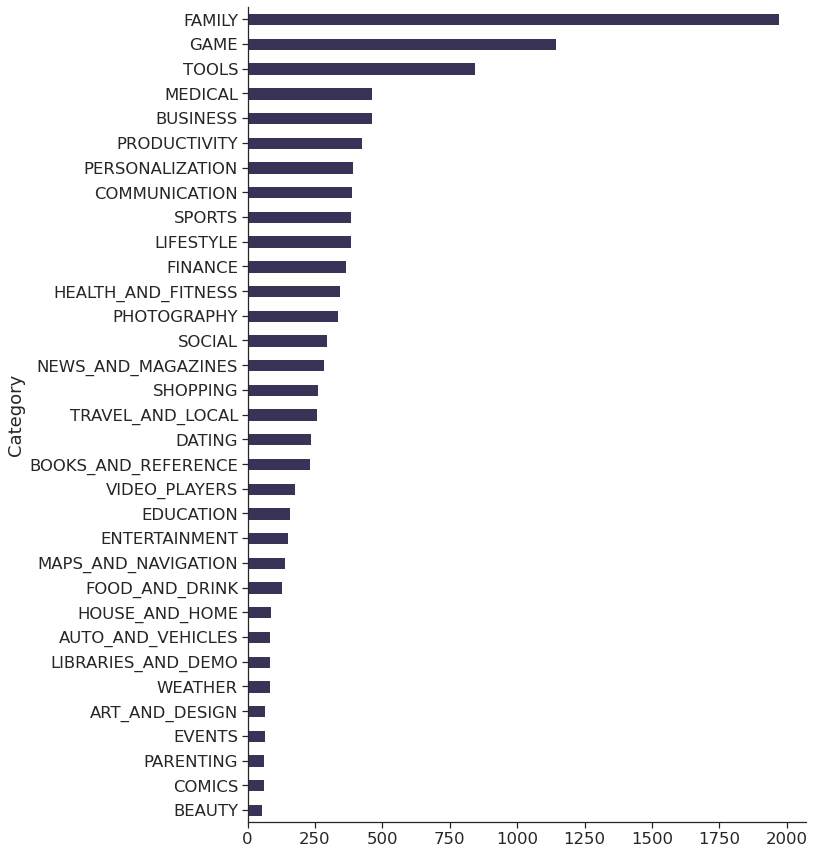

In [34]:
df_plt = df.groupby('Category').size().sort_values(ascending=False)
df_plt.plot.barh(y='Category', figsize=(10,15), legend=False)
plt.gca().invert_yaxis()
plt.show()

## `Rating` column

In [35]:
# # FORMULA TO REMOVE OUTLIER

# Q1 = df['Rating'].quantile(0.25)
# Q3 = df['Rating'].quantile(0.75)
# IQR = Q3 - Q1    #IQR is interquartile range. 

# filter = (df['Rating'] >= Q1 - 1.5 * IQR) & (df['Rating'] <= Q3 + 1.5 *IQR)
# df.loc[filter]  

# ax = df.loc[filter][['Rating']].boxplot(figsize=(8, 8))
# ax.figure.suptitle('')
# ax.set_title('Rating Distribution')
# ax.set_ylabel('Rating')

In [36]:
# ax = df[['Rating']].boxplot(figsize=(8, 8))
# ax.figure.suptitle('')
# ax.set_title('Rating Distribution')
# ax.set_ylabel('Rating')

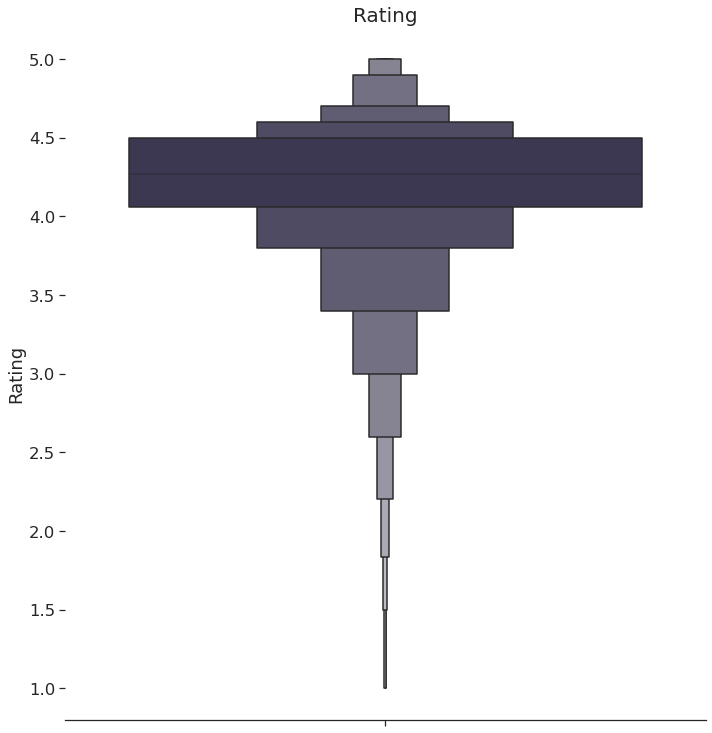

In [37]:
g = sns.catplot(y='Rating', data=df[['Rating']], kind='boxen', height = 10)
g.despine(left=True)
g.set_xticklabels()
g.set_ylabels('Rating')
g.set_xlabels('')
plt.title('Rating', size = 20)
plt.show()

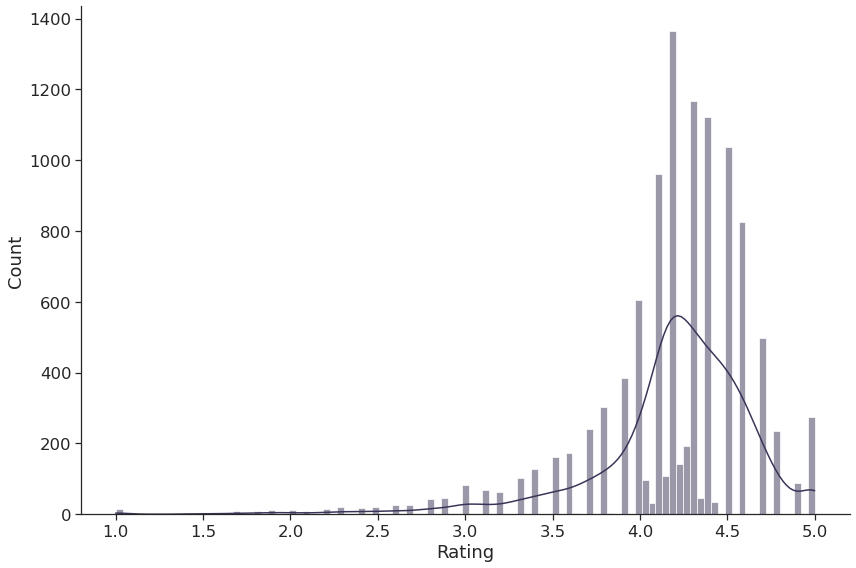

In [38]:
ax = sns.displot(df['Rating'], kind='hist', kde=True, height=8,aspect=1.5)
plt.show()

## `Reviews` column

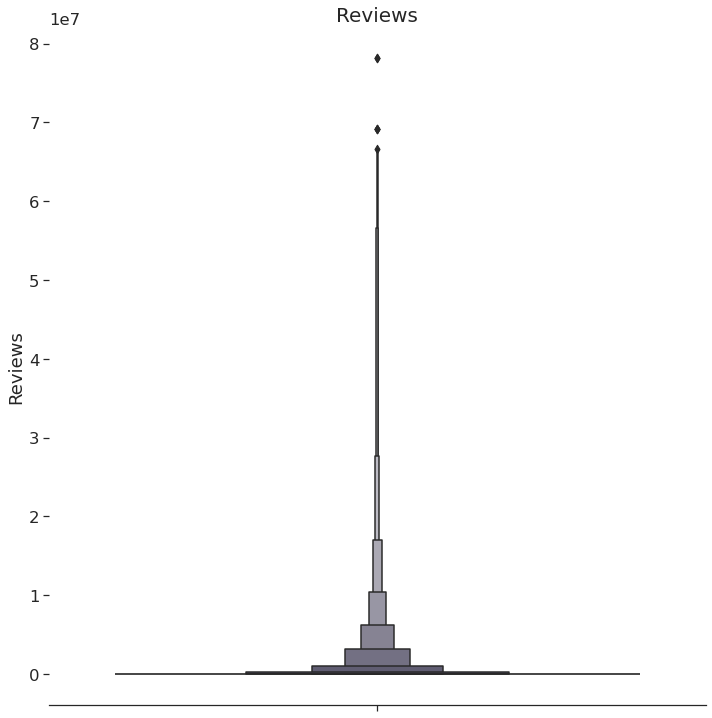

In [39]:
g = sns.catplot(y='Reviews', data=df[['Reviews']], kind='boxen', height = 10)
g.despine(left=True)
g.set_xticklabels()
g.set_ylabels('Reviews')
g.set_xlabels('')
plt.title('Reviews', size = 20)
plt.show()

In [40]:
# Q1 = df['Reviews'].quantile(0.25)
# Q3 = df['Reviews'].quantile(0.75)
# IQR = Q3 - Q1    #IQR is interquartile range. 

# filter = (df['Reviews'] >= Q1 - 1.5 * IQR) & (df['Reviews'] <= Q3 + 1.5 *IQR)
# df.loc[filter]  

# ax = df.loc[filter][['Reviews']].boxplot(figsize=(8, 8))
# ax.figure.suptitle('')
# ax.set_title('Rating Distribution')
# ax.set_ylabel('Rating')

## `Installs` column

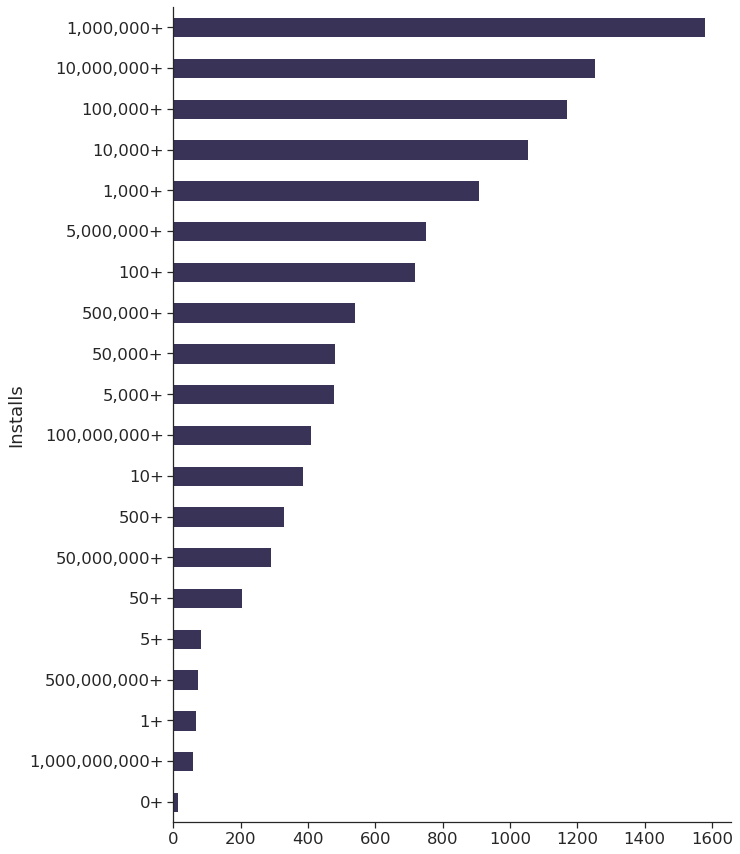

In [41]:
df_plt = df.groupby('Installs').size().sort_values()
df_plt.plot.barh(y='Installs', figsize=(10,15), legend=False)
#plt.gca().invert_yaxis()
plt.show()

## `Type` column

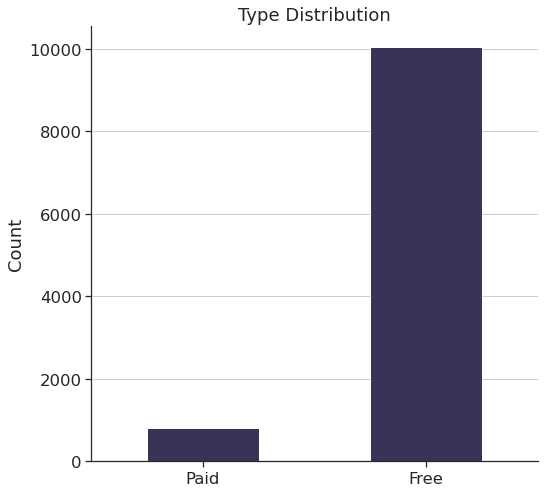

In [42]:
ax = df.groupby('Type').size().sort_values().plot(kind='bar', figsize=(8,8))
ax.set_title('Type Distribution')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Paid', 'Free'], rotation='horizontal');
ax.grid(axis='y')

## `Price` column

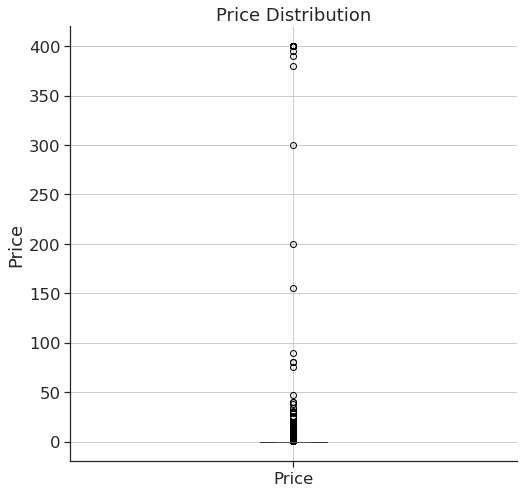

In [43]:
ax = df[['Price']].boxplot(figsize=(8, 8),
                           notch=True,
                           showcaps=False)
ax.figure.suptitle('')
ax.set_title('Price Distribution')
ax.set_ylabel('Price')
plt.show()

In [44]:
# Q1 = df['Price'].quantile(0.25)
# Q3 = df['Price'].quantile(0.75)
# IQR = Q3 - Q1    #IQR is interquartile range. 

# filter = (df['Price'] >= Q1 - 1.5 * IQR) & (df['Price'] <= Q3 + 1.5 *IQR)
# df.loc[filter]  

# ax = df.loc[filter][['Price']].boxplot(figsize=(8, 8))
# ax.figure.suptitle('')
# ax.set_title('Price Distribution')
# ax.set_ylabel('Price')

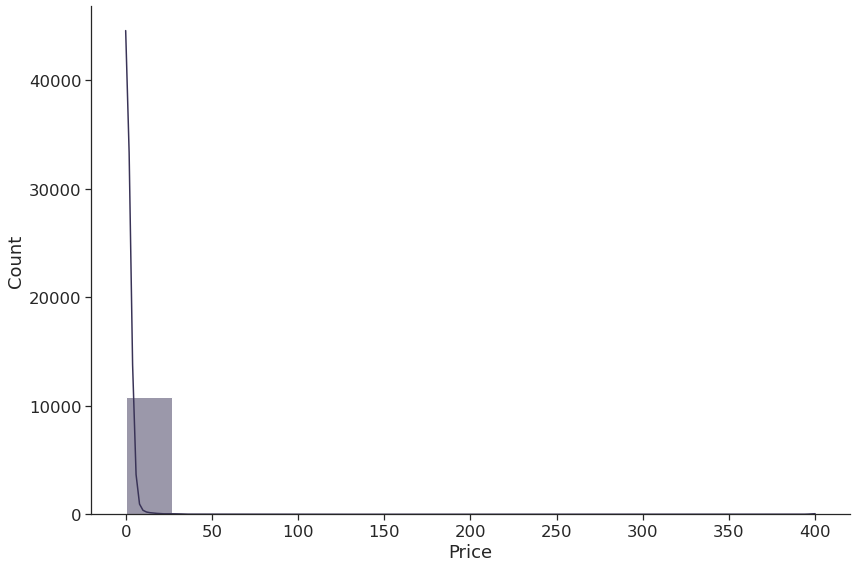

In [45]:
ax = sns.displot(df['Price'], kind='hist', kde=True, height=8,aspect=1.5)
plt.show()

### `Paid` only `Price` column

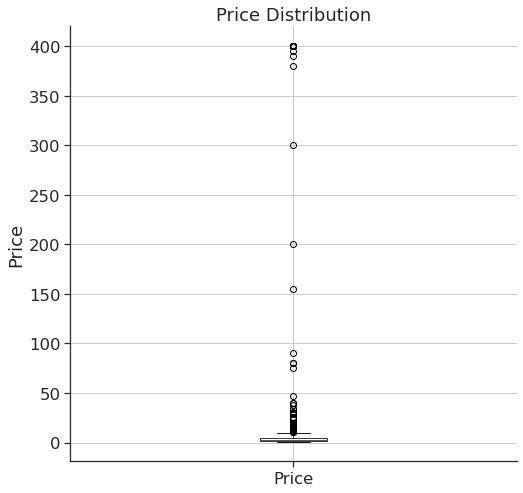

In [46]:
ax = df.loc[df['Type'] == 'Paid'][['Price']].boxplot(figsize=(8, 8))
ax.figure.suptitle('')
ax.set_title('Price Distribution')
ax.set_ylabel('Price')
plt.show()

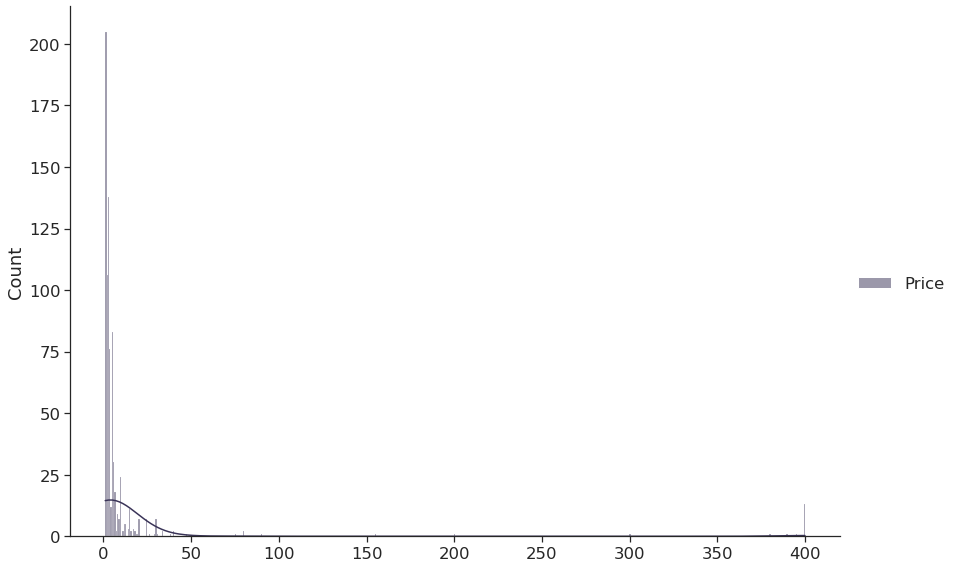

In [47]:
ax = sns.displot(df.loc[df['Type'] == 'Paid'][['Price']], kind='hist', kde=True, height=8,aspect=1.5)
plt.show()

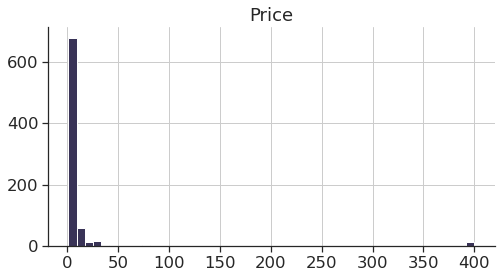

In [48]:
df[df['Price'] > 0][['Price']].hist(layout=(5, 1), figsize=(8, 25), bins=50)
plt.show()

## `Content Rating`

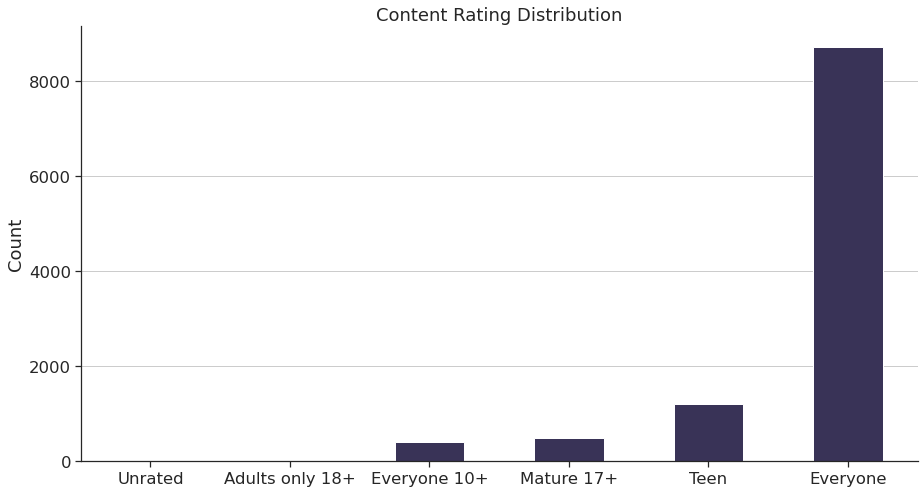

In [49]:
ax = df.groupby('Content Rating').size().sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Content Rating Distribution')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Unrated', 'Adults only 18+', 'Everyone 10+', 'Mature 17+', 'Teen', 'Everyone'], rotation='horizontal');
ax.grid(axis='y')

## `Last Updated` column

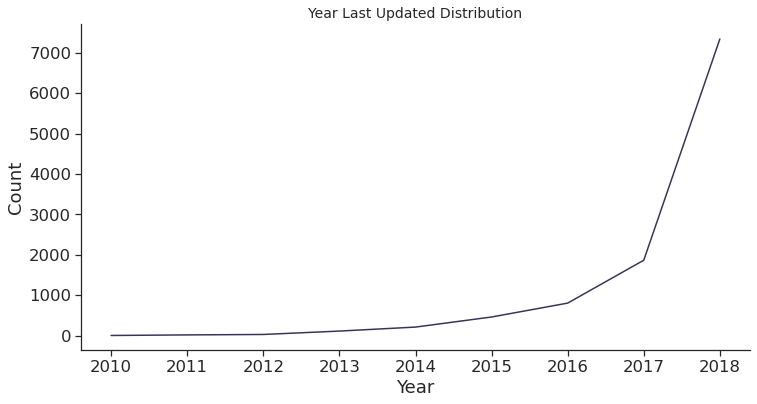

In [50]:
Temp = df.groupby(df['Last Updated'].dt.year)[['Last Updated']].count() #Temp is going to be temporary data frame
Temp = Temp.rename(columns={"Last Updated": "Count"})
Temp
plt.figure(figsize=(12,6))
sns.lineplot(data=Temp, x='Last Updated', y='Count', markers=True, dashes=False)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Year Last Updated Distribution', loc='Center', fontsize=14)
plt.show()

## `Genre Main` column 

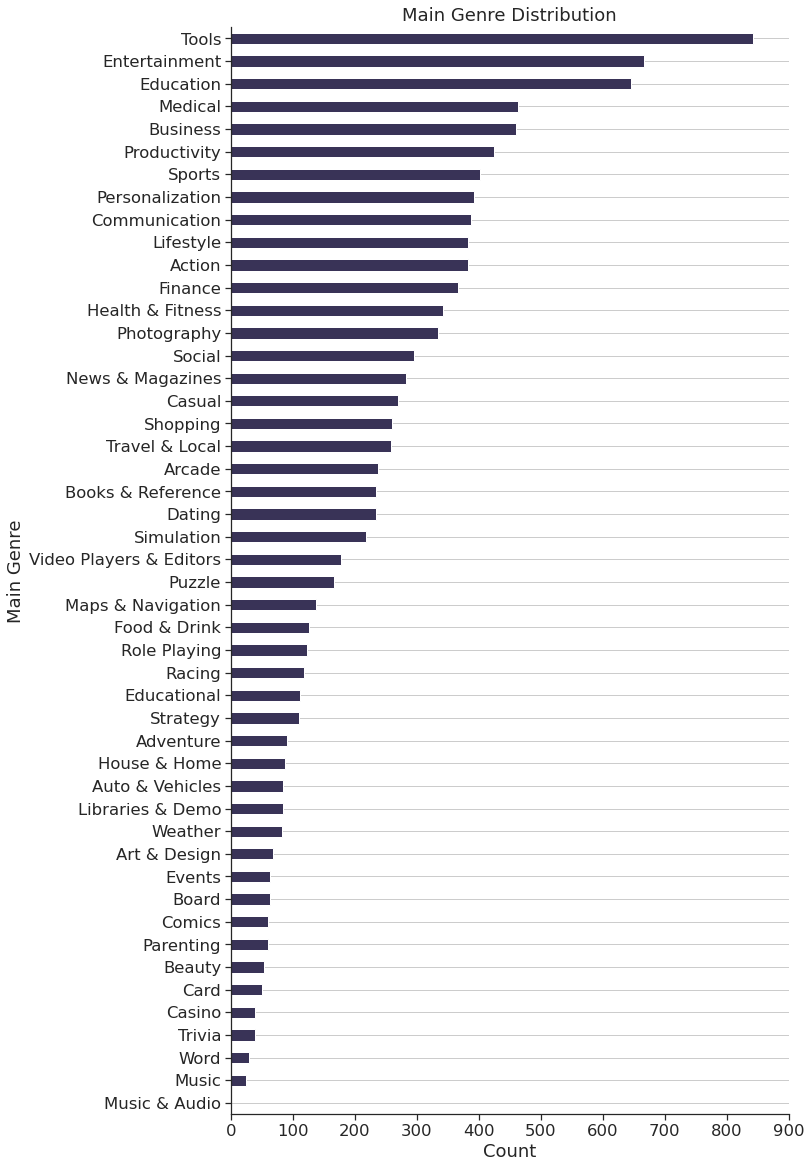

In [51]:
ax = df.groupby('Genre Main').size().sort_values().plot(kind='barh', figsize=(10, 20))
ax.set_title('Main Genre Distribution')
ax.set_xlabel('Count')
ax.set_ylabel('Main Genre')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## `Genre Sub` column

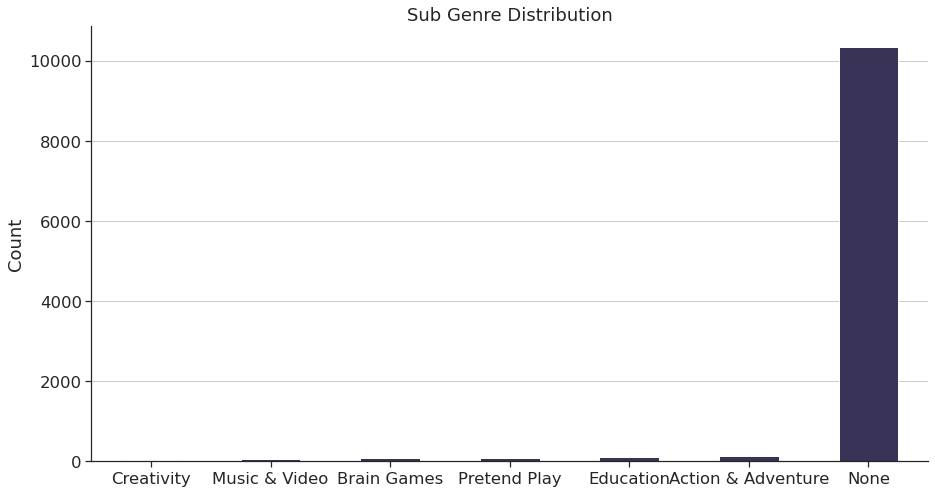

In [52]:
ax = df.groupby('Genre Sub').size().sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Sub Genre Distribution')
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Creativity', 'Music & Video', 'Brain Games', 
                         'Pretend Play', 'Education', 'Action & Adventure', 
                         'None'], rotation='horizontal');
ax.grid(axis='y')

## `Size in MB` column

Text(0, 0.5, 'Size in MB')

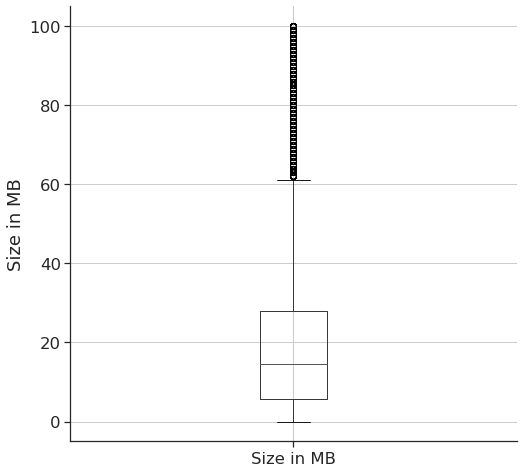

In [53]:
ax = df[['Size in MB']].boxplot(figsize=(8, 8))
ax.figure.suptitle('')
ax.set_title('')
ax.set_ylabel('Size in MB')

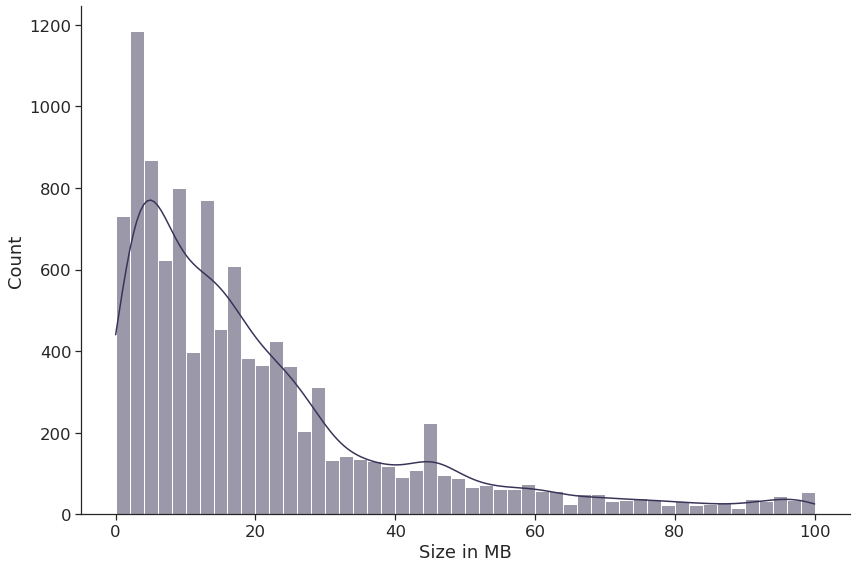

In [54]:
ax = sns.displot(df['Size in MB'], kind='hist', kde=True, height=8,aspect=1.5)
plt.show()

# Installs_Min column

In [159]:
gpsa1 = data.copy()
df1 = gpsa1.sort_values(['App', 'Installs_Min'], ascending=[True, False])
most_reviews = df1['Installs_Min'] == 1000000000
df1 = df1[most_reviews]
# df1 = df1.drop_duplicates(subset='App')
print(df1.shape)
df1

(20, 15)


App_ID                                       App             Category  \
2793    2002                                  Facebook               SOCIAL   
371      304                                     Gmail        COMMUNICATION   
3563    2506                                    Google                TOOLS   
366      302              Google Chrome: Fast & Secure        COMMUNICATION   
3812    2719                              Google Drive         PRODUCTIVITY   
4135    2976                               Google News   NEWS_AND_MAGAZINES   
3101    2191                             Google Photos          PHOTOGRAPHY   
160      152                         Google Play Books  BOOKS_AND_REFERENCE   
960      701                         Google Play Games               FAMILY   
4075    2929                   Google Play Movies & Tv        VIDEO_PLAYERS   
3471    2428                        Google Street View     TRAVEL_AND_LOCAL   
2818    2012                                   Google+               SOCIAL   
375      305                                  Hangouts        COMMUNICATION   
2797    2003                                 Instagram               SOCIAL   
3458    2419                 Maps - Navigate & Explore     TRAVEL_AND_LOCAL   
359      299  Messenger – Text And Video Chat For Free        COMMUNICATION   
463      349             Skype - Free Im & Video Calls        COMMUNICATION   
1810    1356                            Subway Surfers                 GAME   
362      300                        Whatsapp Messenger        COMMUNICATION   
4047    2907                                   Youtube        VIDEO_PLAYERS   

      Rating   Reviews        Installs  Type  Price Content Rating  \
2793     4.1  78128208  1,000,000,000+  Free    0.0           Teen   
371      4.3   4604324  1,000,000,000+  Free    0.0       Everyone   
3563     4.4   8021623  1,000,000,000+  Free    0.0       Everyone   
366      4.3   9642112  1,000,000,000+  Free    0.0       Everyone   
3812     4.4   2728941  1,000,000,000+  Free    0.0       Everyone   
4135     3.9    878065  1,000,000,000+  Free    0.0           Teen   
3101     4.5  10847682  1,000,000,000+  Free    0.0       Everyone   
160      3.9   1433233  1,000,000,000+  Free    0.0           Teen   
960      4.3   7168735  1,000,000,000+  Free    0.0           Teen   
4075     3.7    906384  1,000,000,000+  Free    0.0           Teen   
3471     4.2   2129707  1,000,000,000+  Free    0.0       Everyone   
2818     4.2   4828372  1,000,000,000+  Free    0.0           Teen   
375      4.0   3419464  1,000,000,000+  Free    0.0       Everyone   
2797     4.5  66509917  1,000,000,000+  Free    0.0           Teen   
3458     4.3   9231613  1,000,000,000+  Free    0.0       Everyone   
359      4.0  56642847  1,000,000,000+  Free    0.0       Everyone   
463      4.1  10484169  1,000,000,000+  Free    0.0       Everyone   
1810     4.5  27711703  1,000,000,000+  Free    0.0   Everyone 10+   
362      4.4  69109672  1,000,000,000+  Free    0.0       Everyone   
4047     4.3  25623548  1,000,000,000+  Free    0.0           Teen   

                       Genres Last Updated               Genre Main Genre Sub  \
2793                   Social   2018-08-03                   Social      None   
371             Communication   2018-08-02            Communication      None   
3563                    Tools   2018-08-03                    Tools      None   
366             Communication   2018-08-01            Communication      None   
3812             Productivity   2018-07-30             Productivity      None   
4135         News & Magazines   2018-08-01         News & Magazines      None   
3101              Photography   2018-08-01              Photography      None   
160         Books & Reference   2018-08-03        Books & Reference      None   
960             Entertainment   2018-07-16            Entertainment      None   
4075  Video Players & Editors   2018-08-06  Video Players & Edito

# Bivariate Analysis

## Average Rating by Category

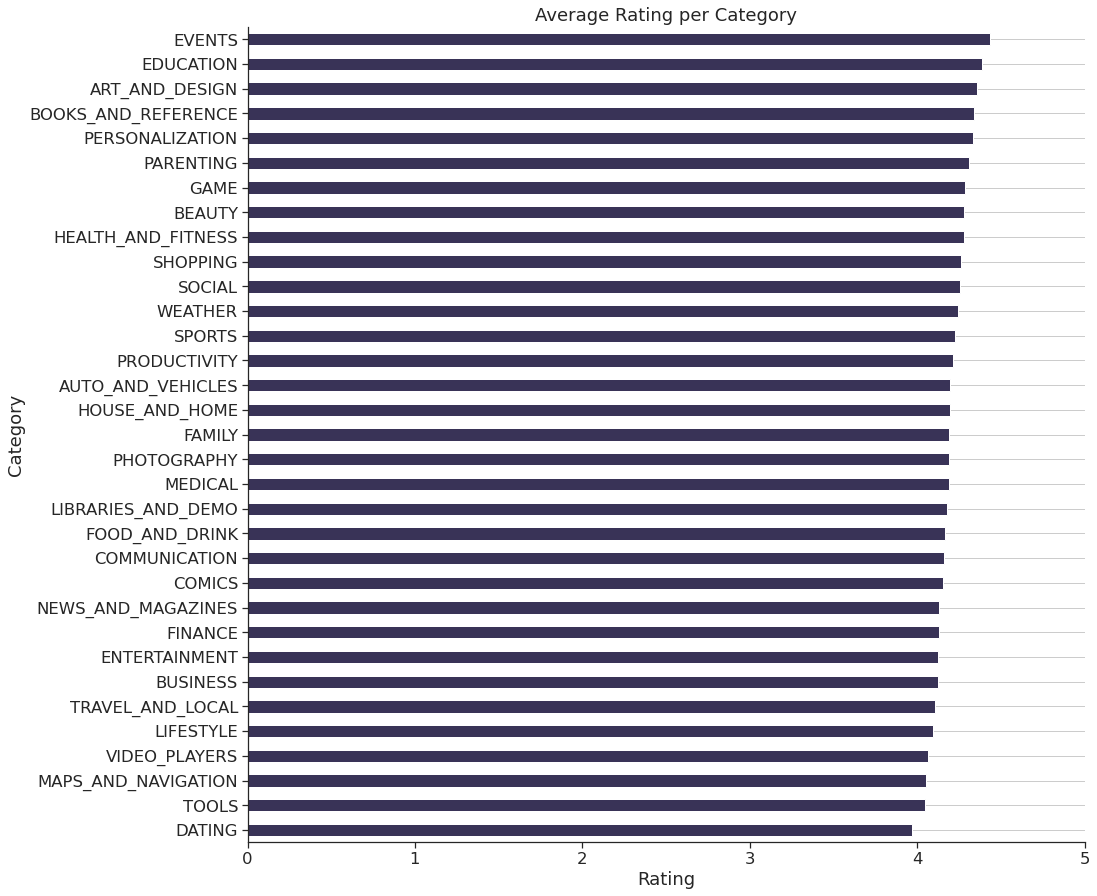

In [55]:
ax = df.groupby('Category').mean()['Rating'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Rating per Category')
ax.set_xlabel('Rating')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Rating by Installs

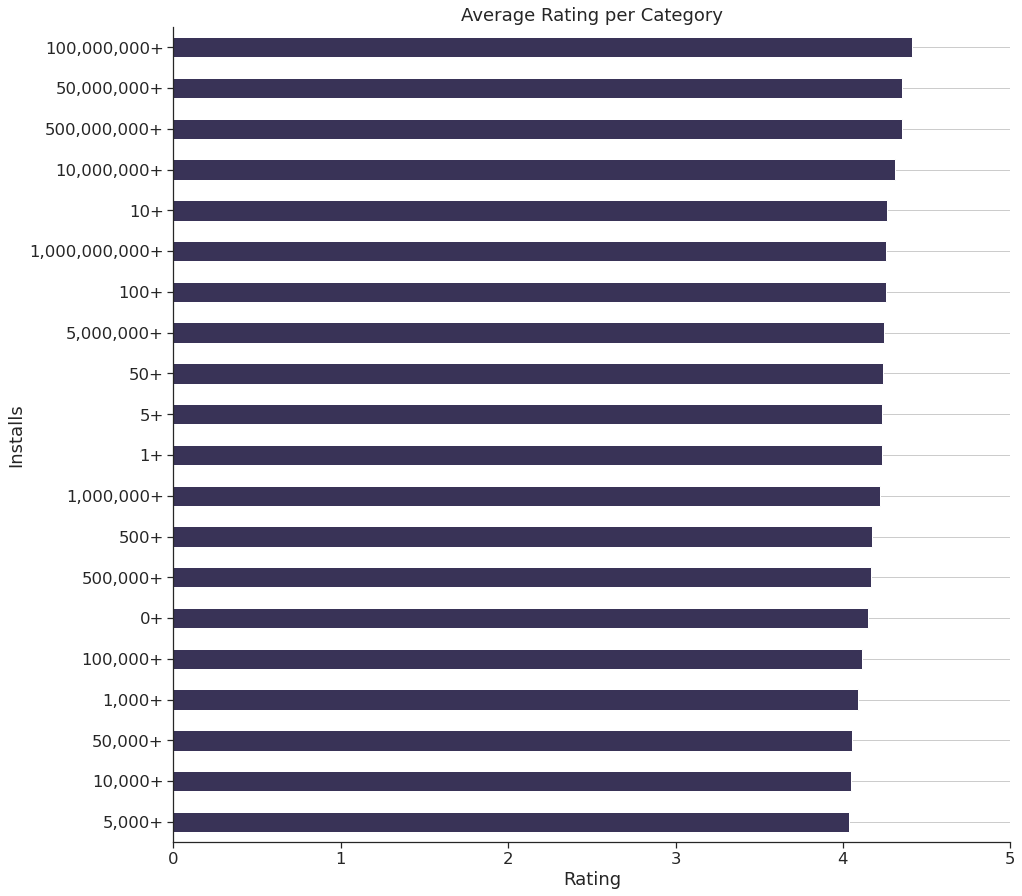

In [56]:
ax = df.groupby('Installs').mean()['Rating'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Rating per Category')
ax.set_xlabel('Rating')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Rating by Type

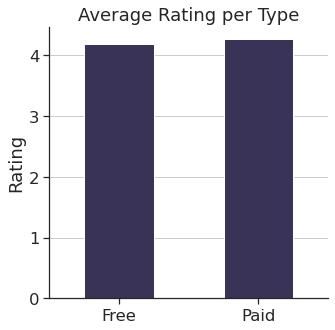

In [57]:
ax = df.groupby('Type').mean()['Rating'].sort_values().plot(kind='bar', figsize=(5,5))
ax.set_title('Average Rating per Type')
ax.set_xlabel('')
ax.set_ylabel('Rating')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Free', 'Paid'], rotation='horizontal');
ax.grid(axis='y')

## Average Rating by Content Rating

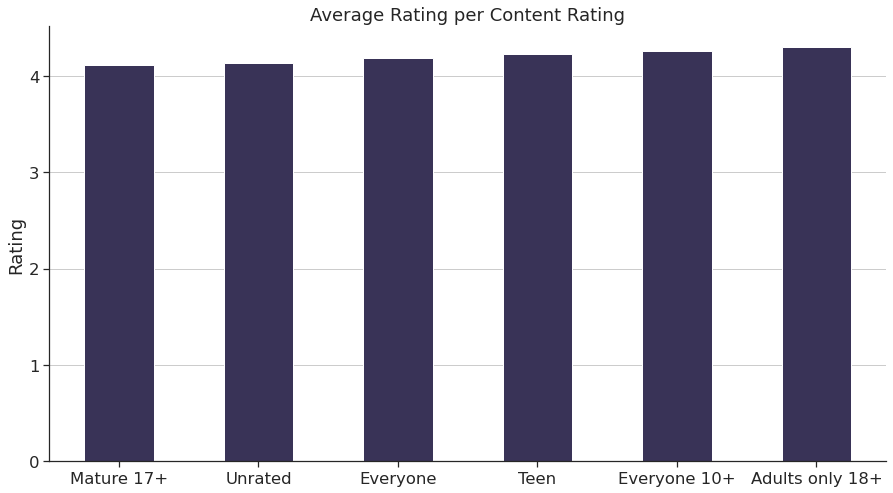

In [58]:
ax = df.groupby('Content Rating').mean()['Rating'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Rating per Content Rating')
ax.set_xlabel('')
ax.set_ylabel('Rating')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Mature 17+', 'Unrated', 'Everyone', 'Teen', 'Everyone 10+', 'Adults only 18+'], rotation='horizontal');
ax.grid(axis='y')

## Average Rating by Main Genre

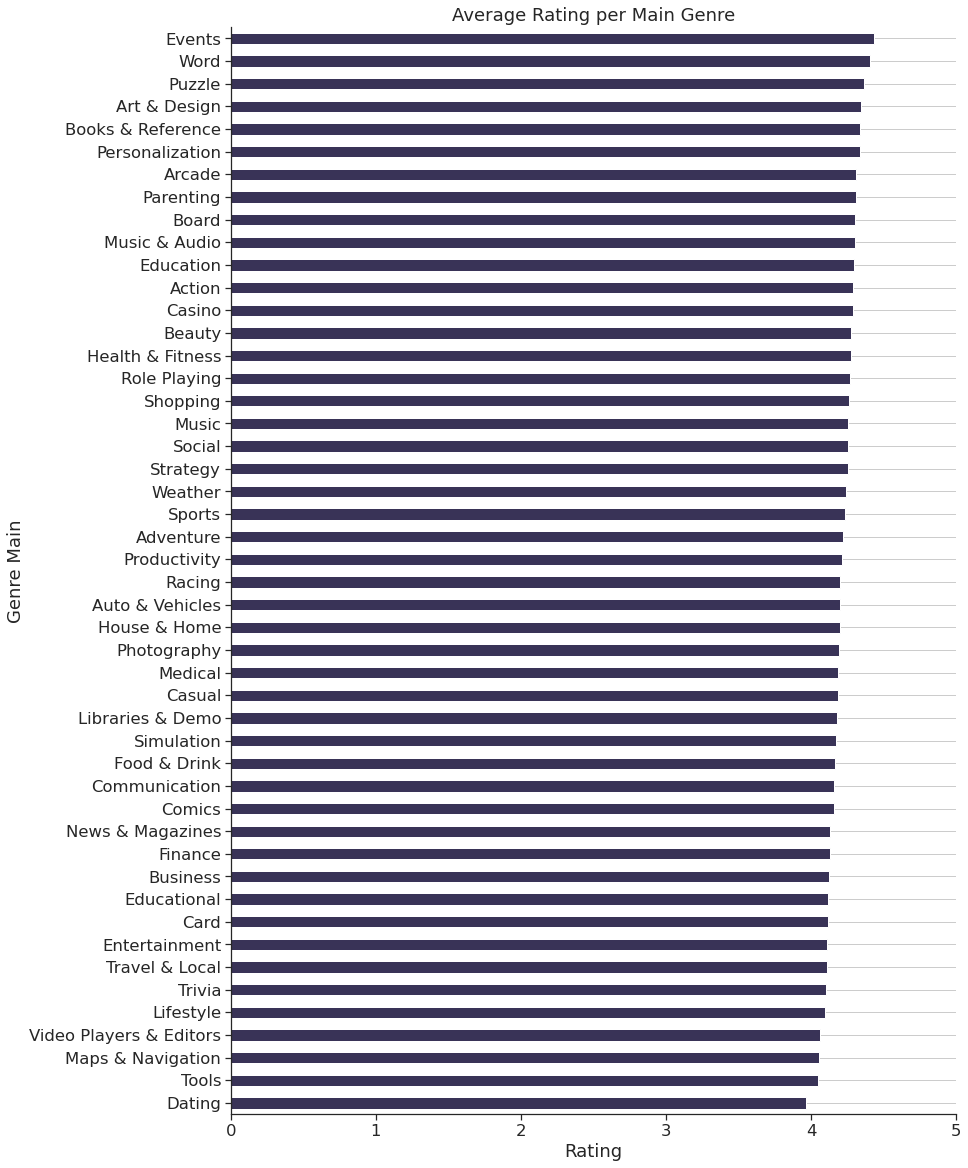

In [59]:
ax = df.groupby('Genre Main').mean()['Rating'].sort_values().plot(kind='barh', figsize=(13,20))
ax.set_title('Average Rating per Main Genre')
ax.set_xlabel('Rating')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Rating by Sub Genre

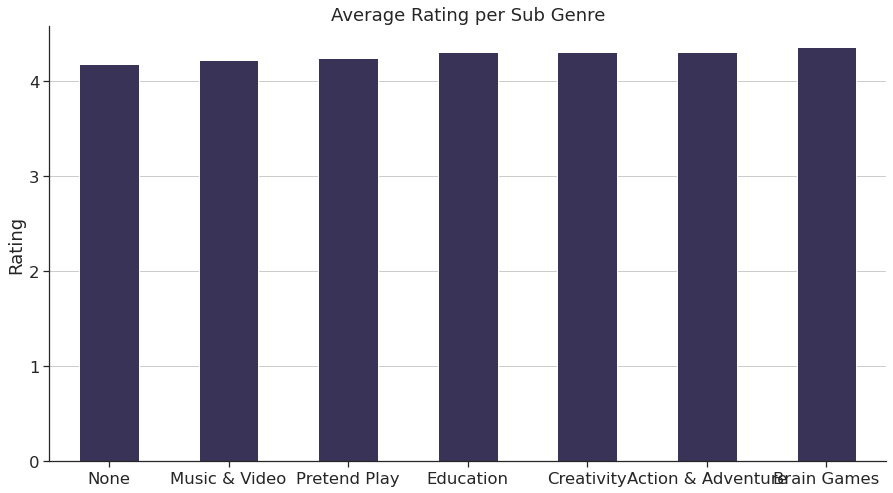

In [60]:
ax = df.groupby('Genre Sub').mean()['Rating'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Rating per Sub Genre')
ax.set_xlabel('')
ax.set_ylabel('Rating')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['None', 'Music & Video', 'Pretend Play', 
                         'Education', 'Creativity', 'Action & Adventure', 
                         'Brain Games'], rotation='horizontal');ax.grid(axis='y')

## Average Reviews by Category

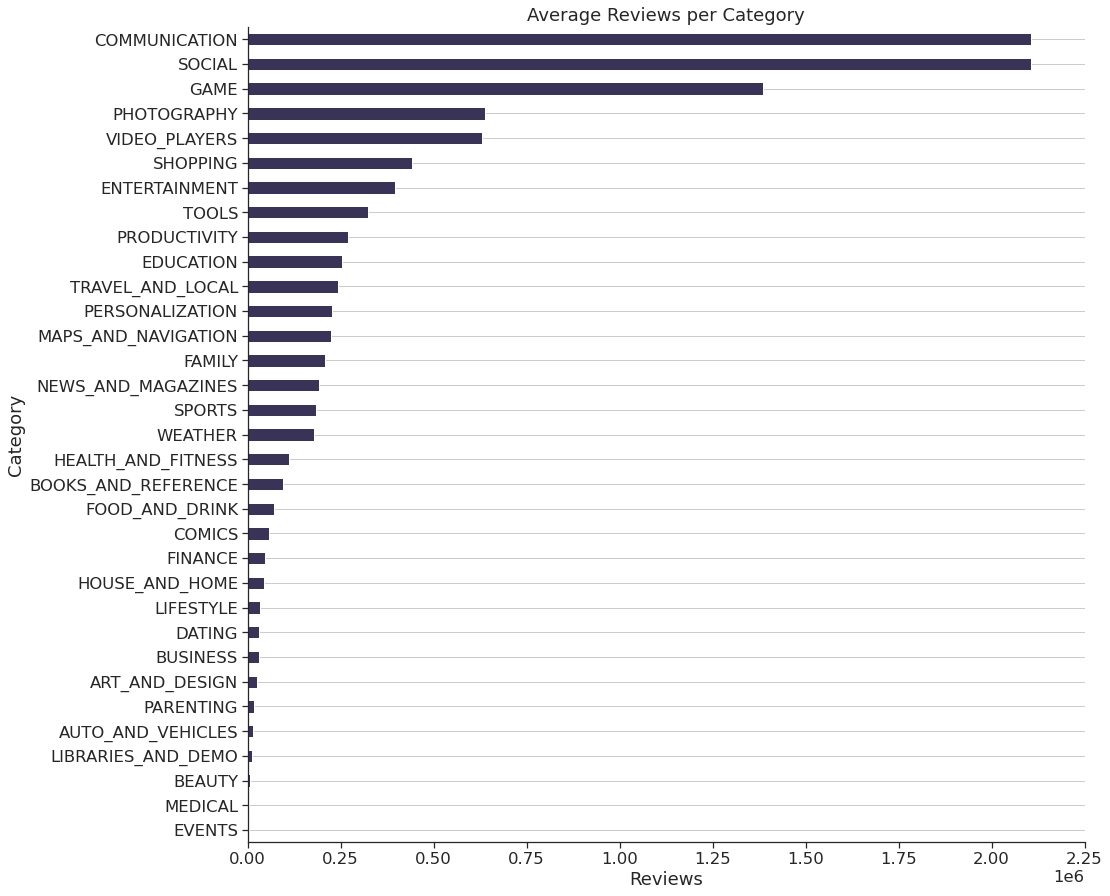

In [61]:
ax = df.groupby('Category').mean()['Reviews'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Reviews per Category')
ax.set_xlabel('Reviews')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Raviews by Installs

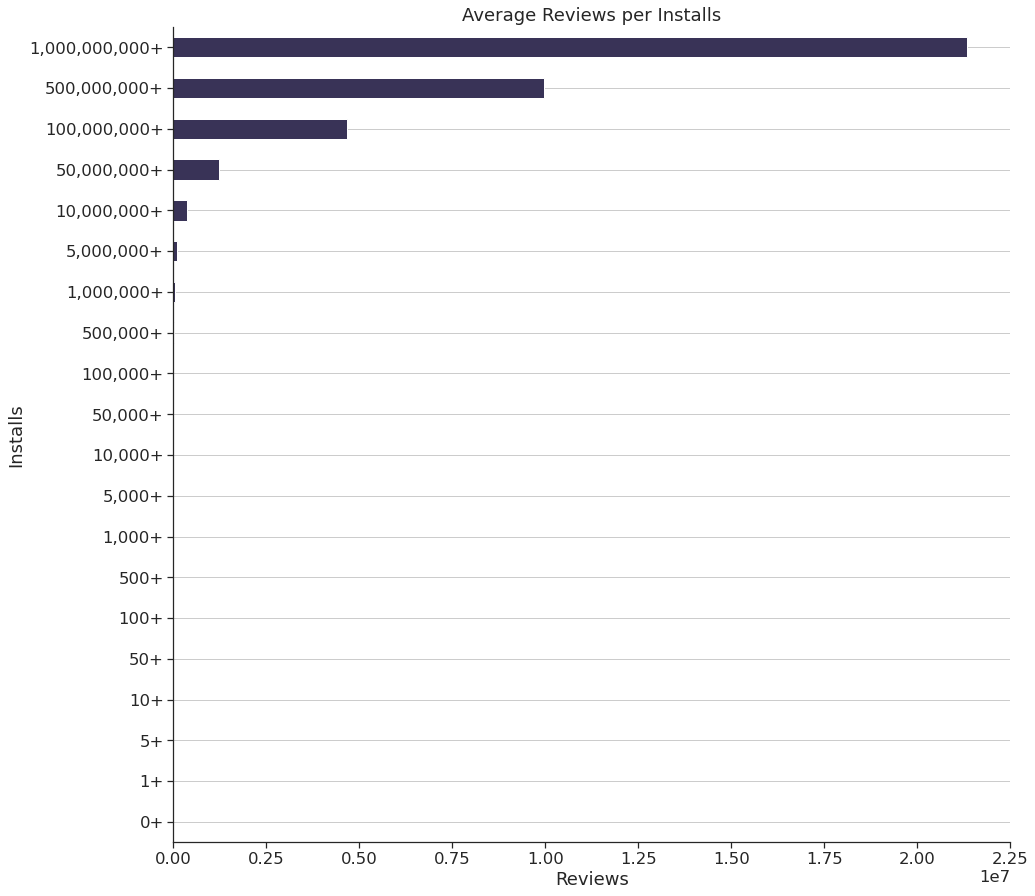

In [62]:
ax = df.groupby('Installs').mean()['Reviews'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Reviews per Installs')
ax.set_xlabel('Reviews')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Reviews by Type

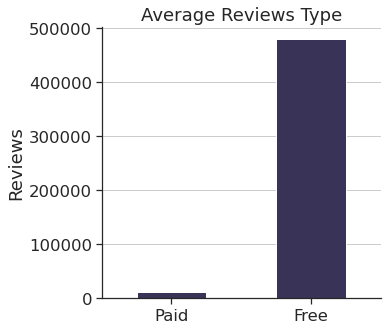

In [63]:
ax = df.groupby('Type').mean()['Reviews'].sort_values().plot(kind='bar', figsize=(5,5))
ax.set_title('Average Reviews Type')
ax.set_xlabel('')
ax.set_ylabel('Reviews')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Paid', 'Free'], rotation='horizontal');
ax.grid(axis='y')

## Average Reviews by Content Rating

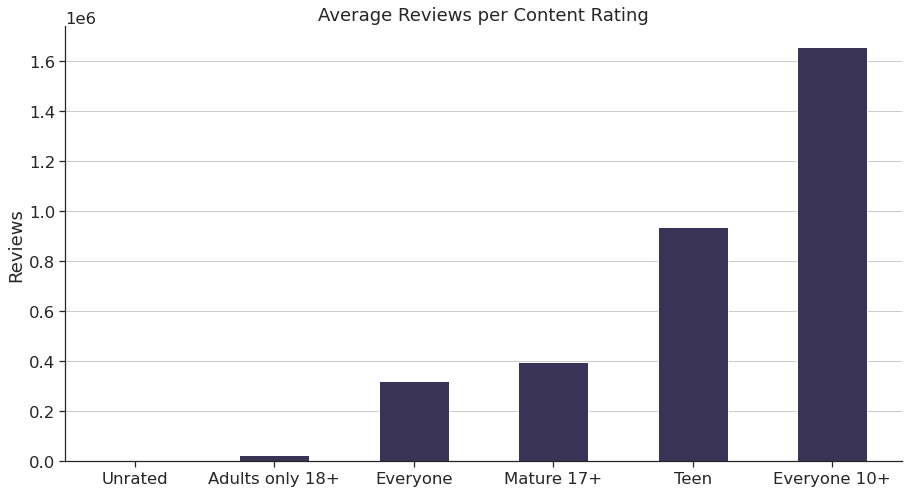

In [64]:
ax = df.groupby('Content Rating').mean()['Reviews'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Reviews per Content Rating')
ax.set_xlabel('')
ax.set_ylabel('Reviews')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Unrated', 'Adults only 18+', 'Everyone', 'Mature 17+', 'Teen', 'Everyone 10+'], rotation='horizontal');
ax.grid(axis='y')

## Average Reviews by Main Genre

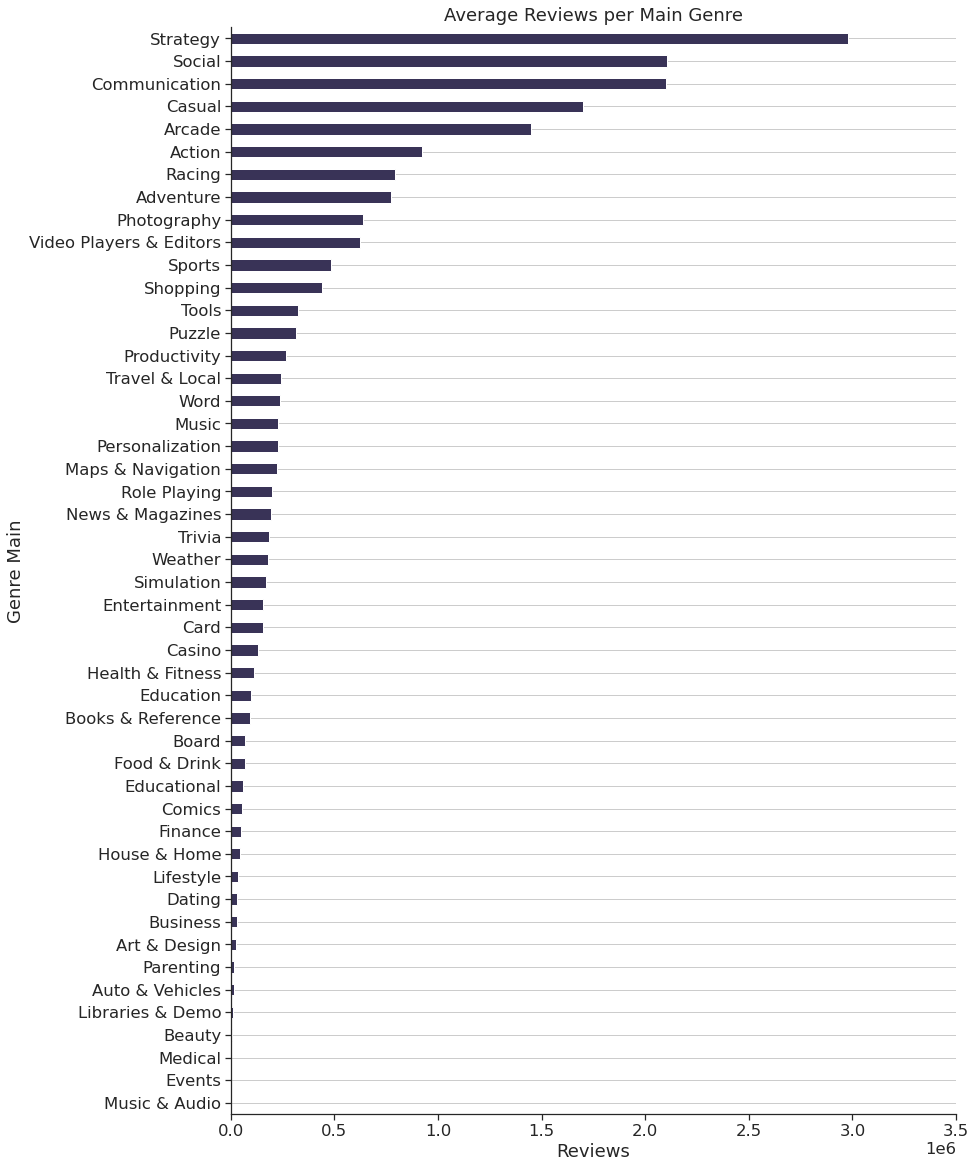

In [65]:
ax = df.groupby('Genre Main').mean()['Reviews'].sort_values().plot(kind='barh', figsize=(13,20))
ax.set_title('Average Reviews per Main Genre')
ax.set_xlabel('Reviews')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Reviews by Sub Genre

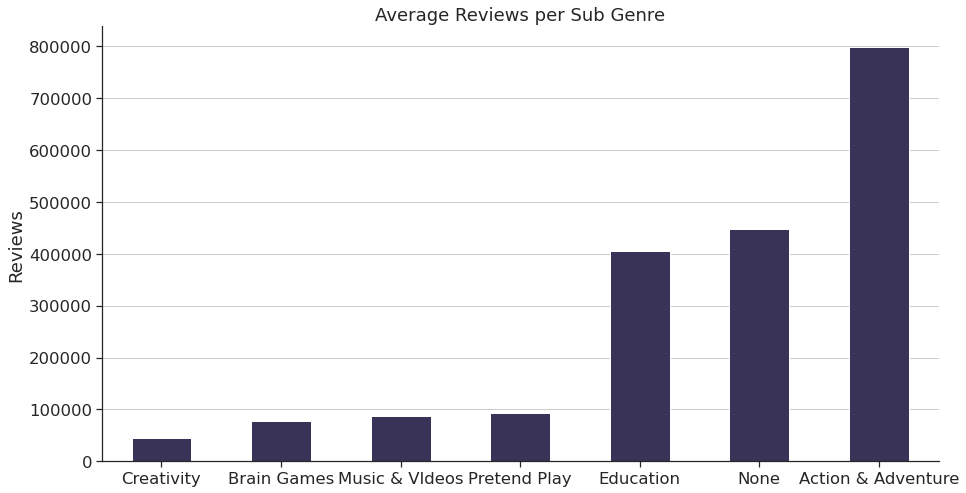

In [66]:
ax = df.groupby('Genre Sub').mean()['Reviews'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Reviews per Sub Genre')
ax.set_xlabel('')
ax.set_ylabel('Reviews')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Creativity', 'Brain Games', 'Music & VIdeos', 
                         'Pretend Play', 'Education', 'None', 
                         'Action & Adventure'], rotation='horizontal');ax.grid(axis='y')

## Average Price by Category (Only Paid Apps)

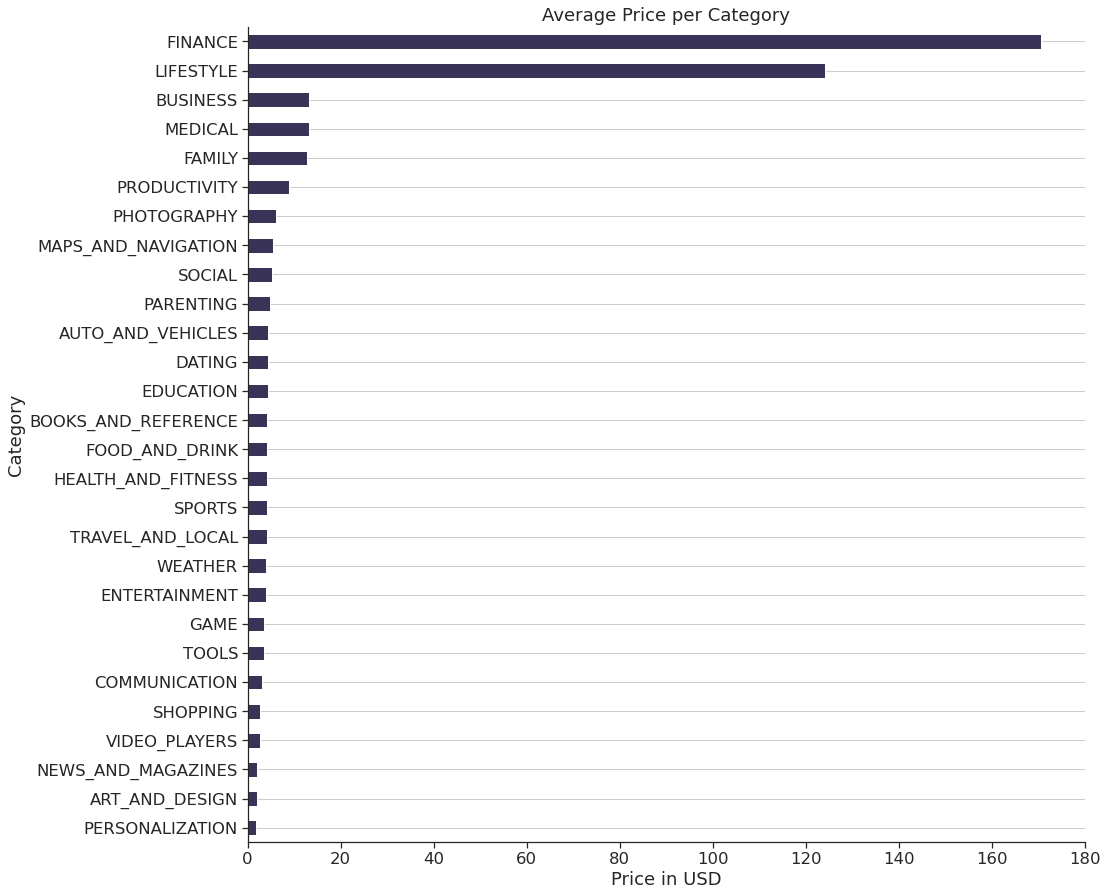

In [67]:
ax = df.loc[df['Type'] == 'Paid'].groupby('Category').mean()['Price'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Price per Category')
ax.set_xlabel('Price in USD')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Price by Installs (Only Paid Apps)

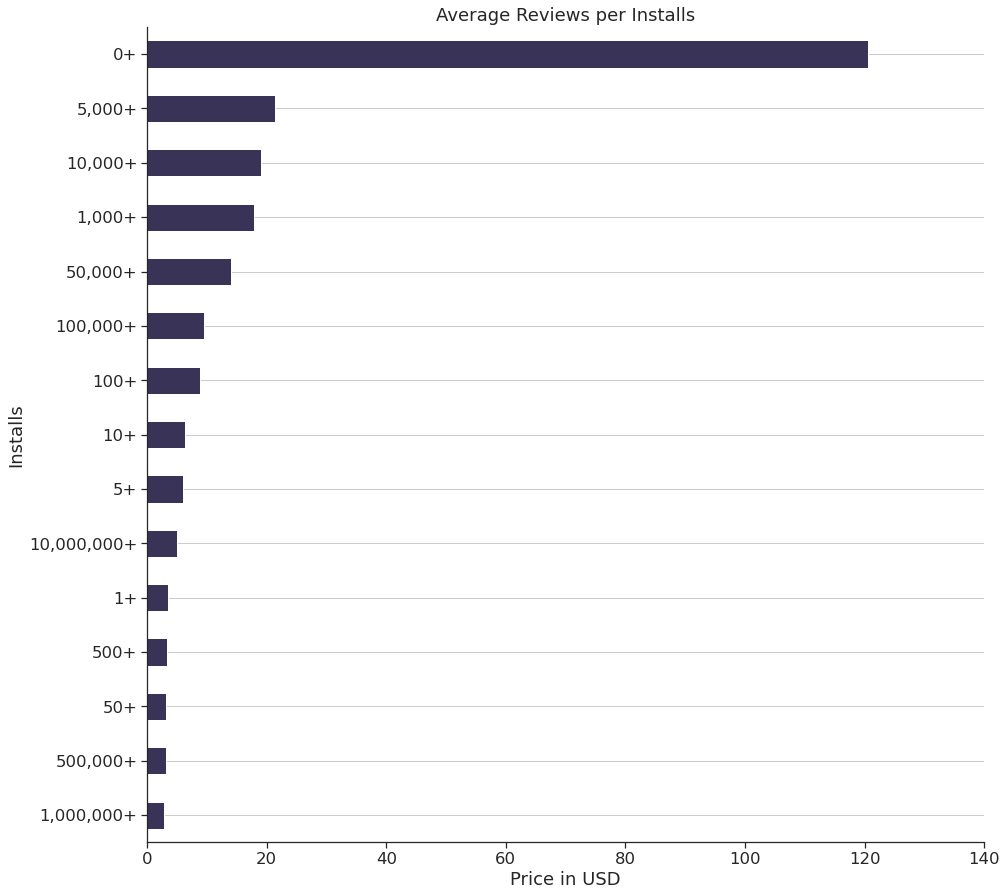

In [68]:
ax = df.loc[df['Type'] == 'Paid'].groupby('Installs').mean()['Price'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Reviews per Installs')
ax.set_xlabel('Price in USD')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Price by Content Rating (Only Paid Apps)

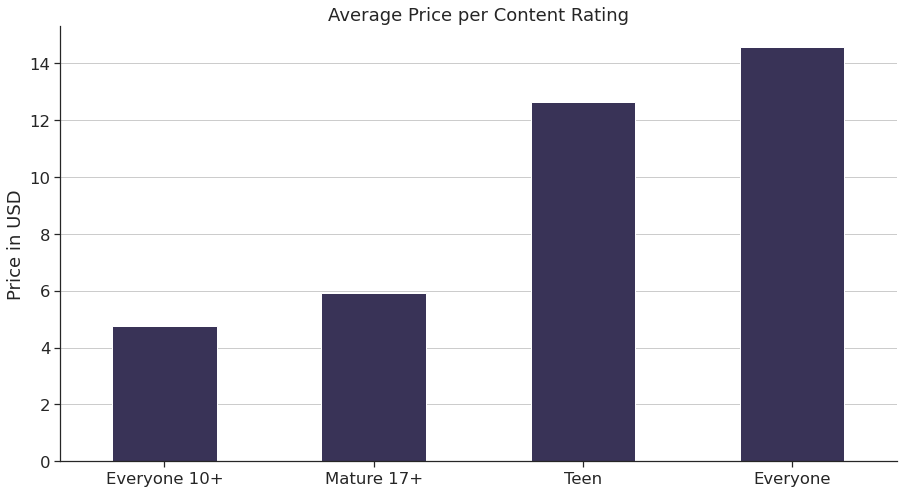

In [69]:
ax = df.loc[df['Type'] == 'Paid'].groupby('Content Rating').mean()['Price'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Price per Content Rating')
ax.set_xlabel('')
ax.set_ylabel('Price in USD')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Everyone 10+', 'Mature 17+', 'Teen', 'Everyone'], rotation='horizontal');
ax.grid(axis='y')

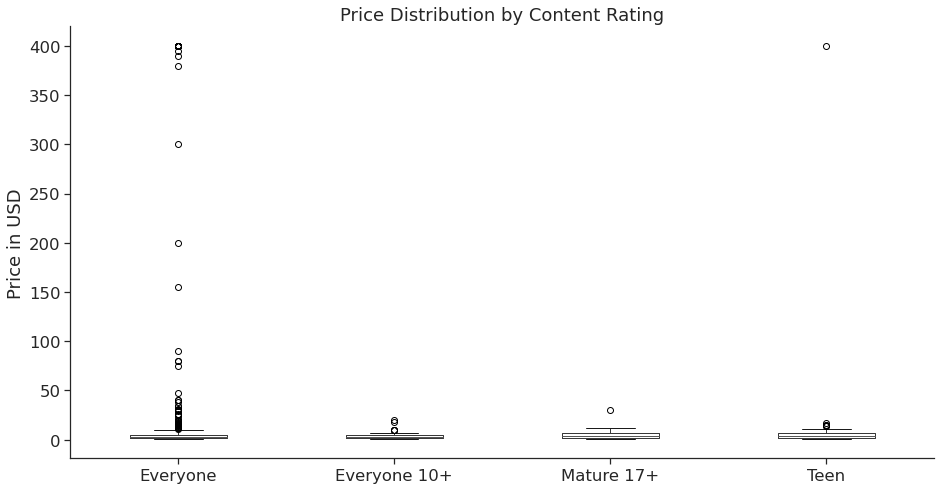

In [70]:
ax = df.loc[df['Type'] == 'Paid'][['Price', 'Content Rating']].boxplot(by='Content Rating',
                                                       grid=False,
                                                       figsize=(15,8))
ax.figure.suptitle('')
ax.set_title('Price Distribution by Content Rating')
ax.set_xlabel('')
ax.set_ylabel('Price in USD')
plt.show()

## Average Price by Main Genre (Only Paid Apps)

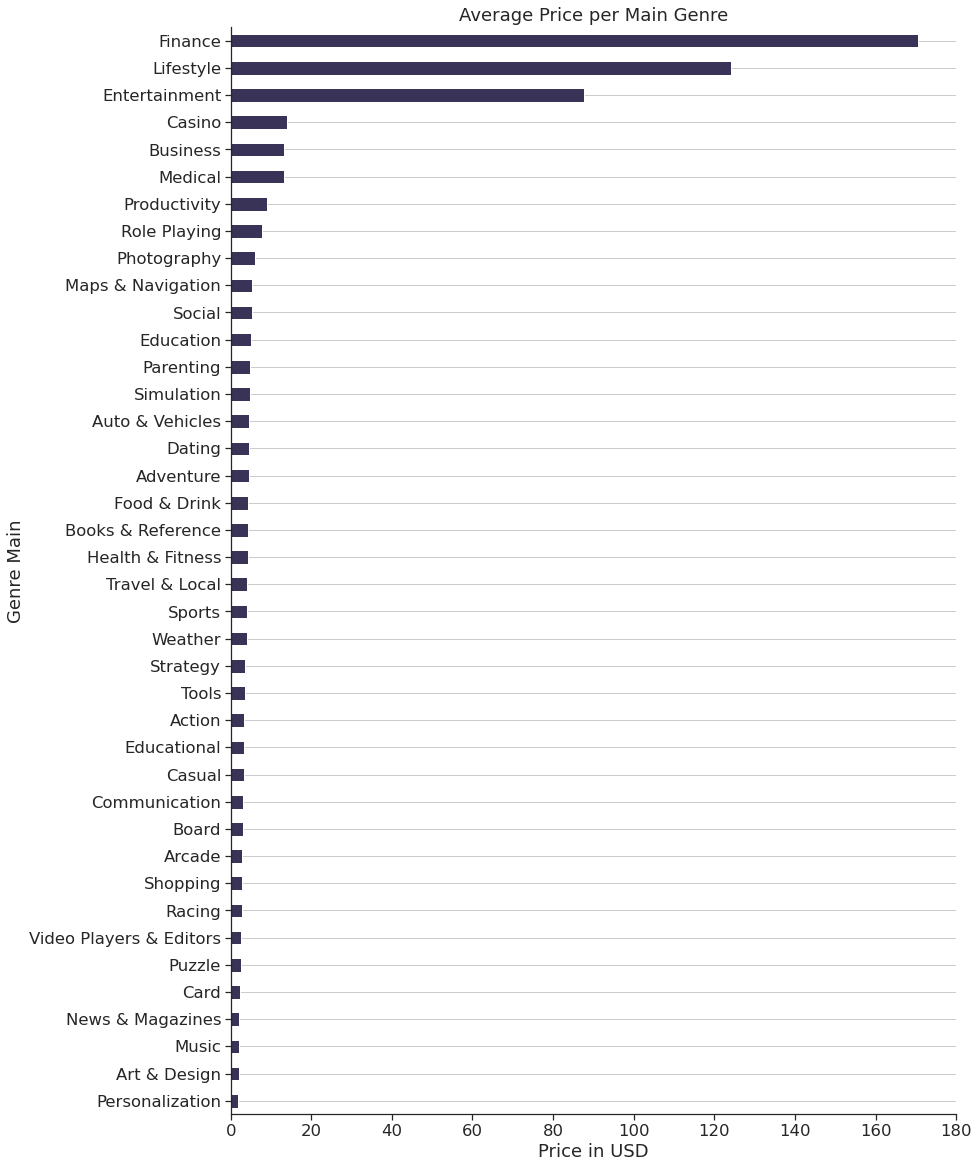

In [71]:
ax = df.loc[df['Type'] == 'Paid'].groupby('Genre Main').mean()['Price'].sort_values().plot(kind='barh', figsize=(13,20))
ax.set_title('Average Price per Main Genre')
ax.set_xlabel('Price in USD')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Price by Sub Genre (Only Paid Apps)

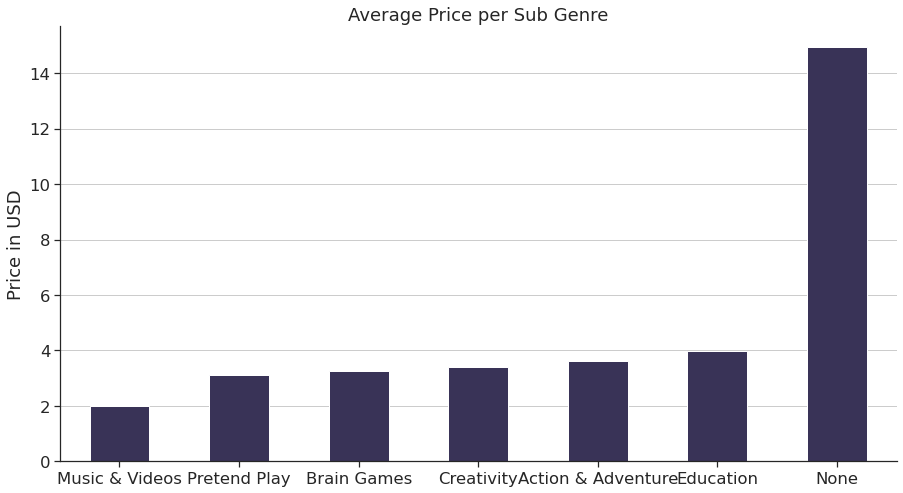

In [72]:
ax = df.loc[df['Type'] == 'Paid'].groupby('Genre Sub').mean()['Price'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Price per Sub Genre')
ax.set_xlabel('')
ax.set_ylabel('Price in USD')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Music & Videos', 'Pretend Play', 'Brain Games', 
                         'Creativity', 'Action & Adventure', 'Education', 
                         'None'], rotation='horizontal');ax.grid(axis='y')

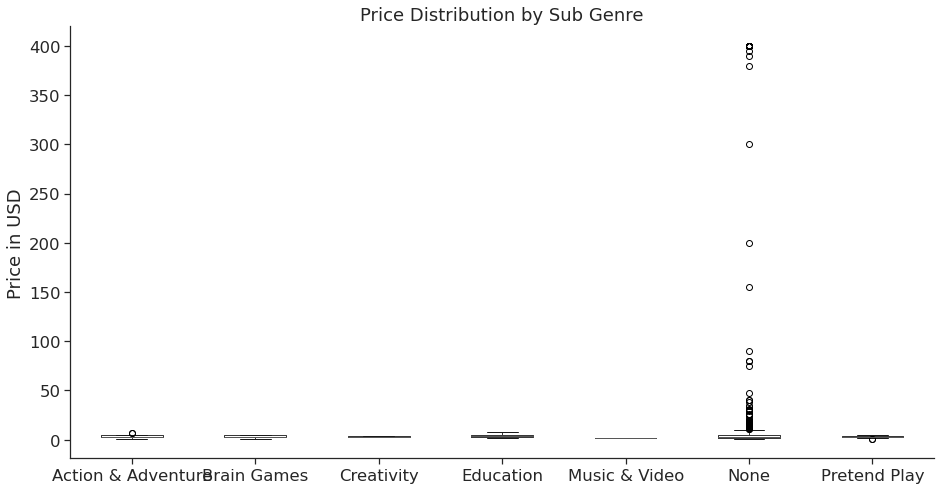

In [73]:
ax = df.loc[df['Type'] == 'Paid'][['Price', 'Genre Sub']].boxplot(by='Genre Sub',
                                                       grid=False,
                                                       figsize=(15,8))
ax.figure.suptitle('')
ax.set_title('Price Distribution by Sub Genre')
ax.set_xlabel('')
ax.set_ylabel('Price in USD')
plt.show()

## Average Size in MB by Category

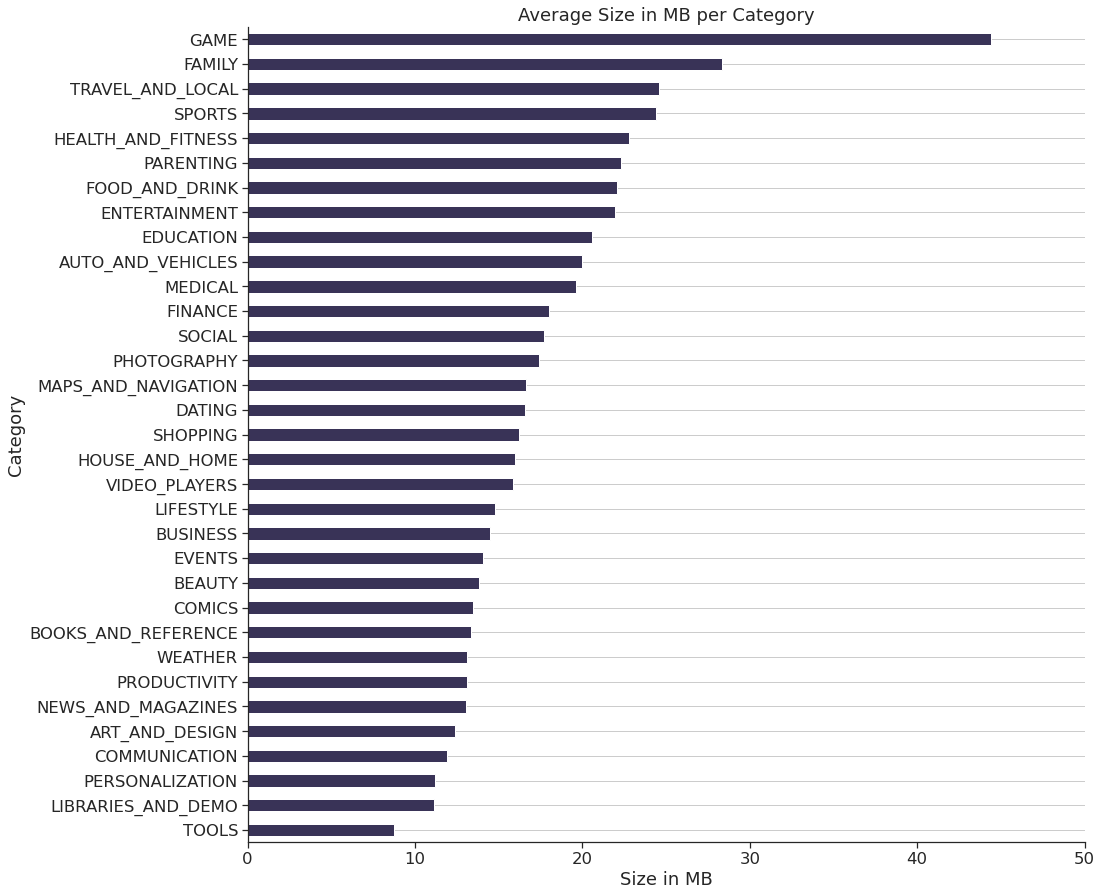

In [74]:
ax = df.groupby('Category').mean()['Size in MB'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Size in MB per Category')
ax.set_xlabel('Size in MB')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Size in MB by Installs

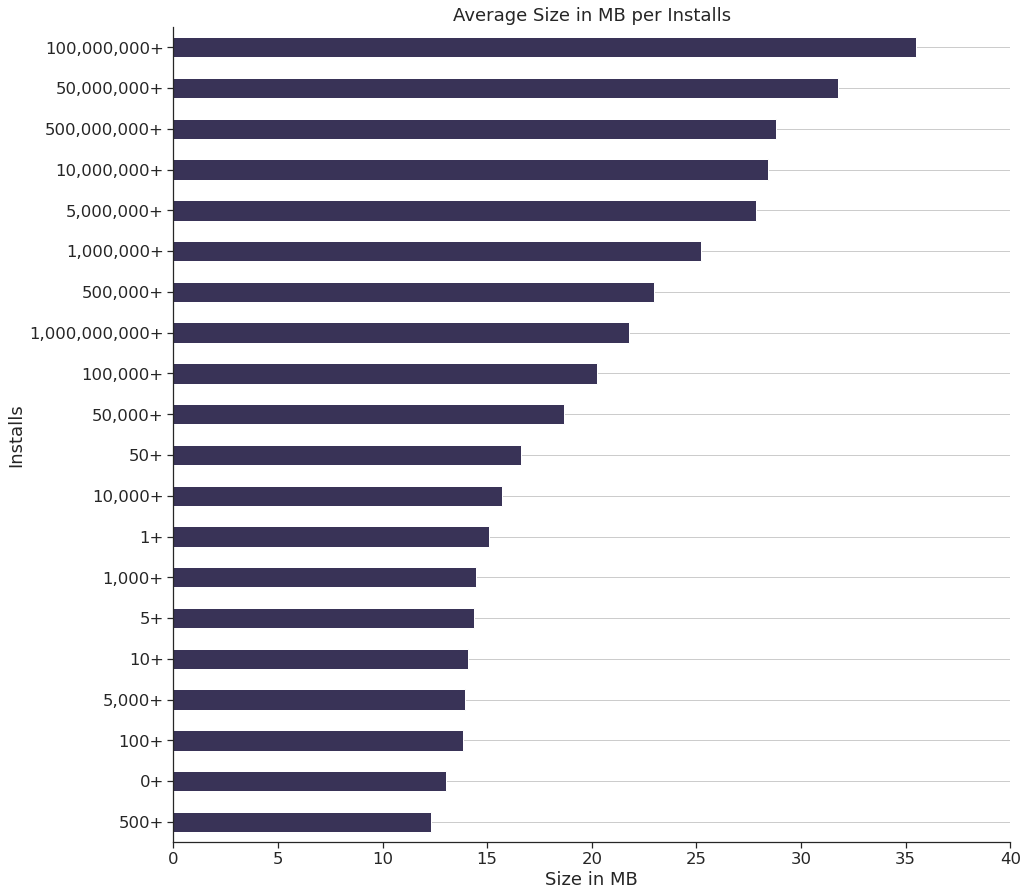

In [75]:
ax = df.groupby('Installs').mean()['Size in MB'].sort_values().plot(kind='barh', figsize=(15,15))
ax.set_title('Average Size in MB per Installs')
ax.set_xlabel('Size in MB')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Size in MB by Type

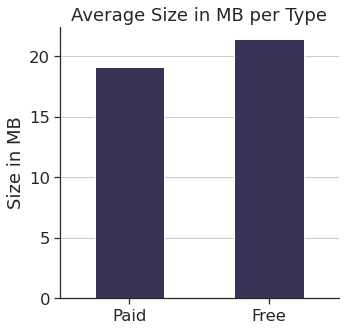

In [76]:
ax = df.groupby('Type').mean()['Size in MB'].sort_values().plot(kind='bar', figsize=(5,5))
ax.set_title('Average Size in MB per Type')
ax.set_xlabel('')
ax.set_ylabel('Size in MB')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Paid', 'Free'], rotation='horizontal');
ax.grid(axis='y')

## Average Size in MB by Content Rating

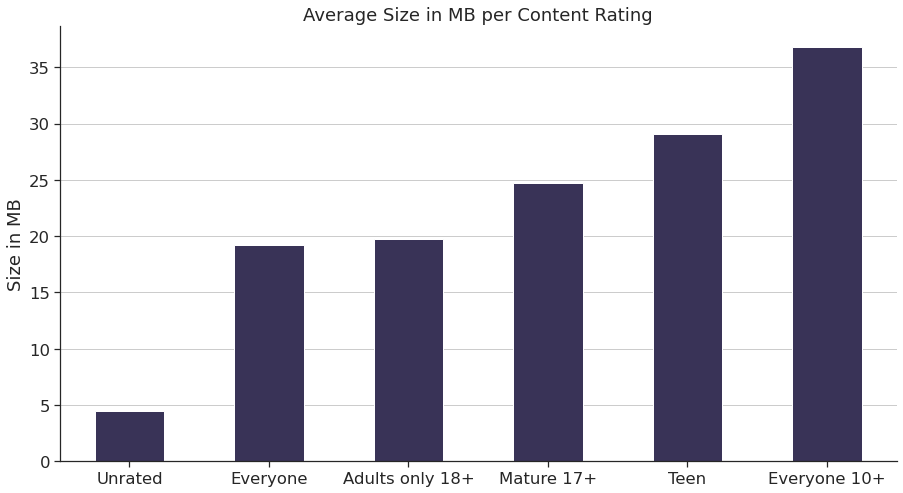

In [77]:
ax = df.groupby('Content Rating').mean()['Size in MB'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Size in MB per Content Rating')
ax.set_xlabel('')
ax.set_ylabel('Size in MB')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['Unrated', 'Everyone', 'Adults only 18+', 'Mature 17+', 'Teen', 'Everyone 10+'], rotation='horizontal');
ax.grid(axis='y')

## Average Size in MB by Main Genre

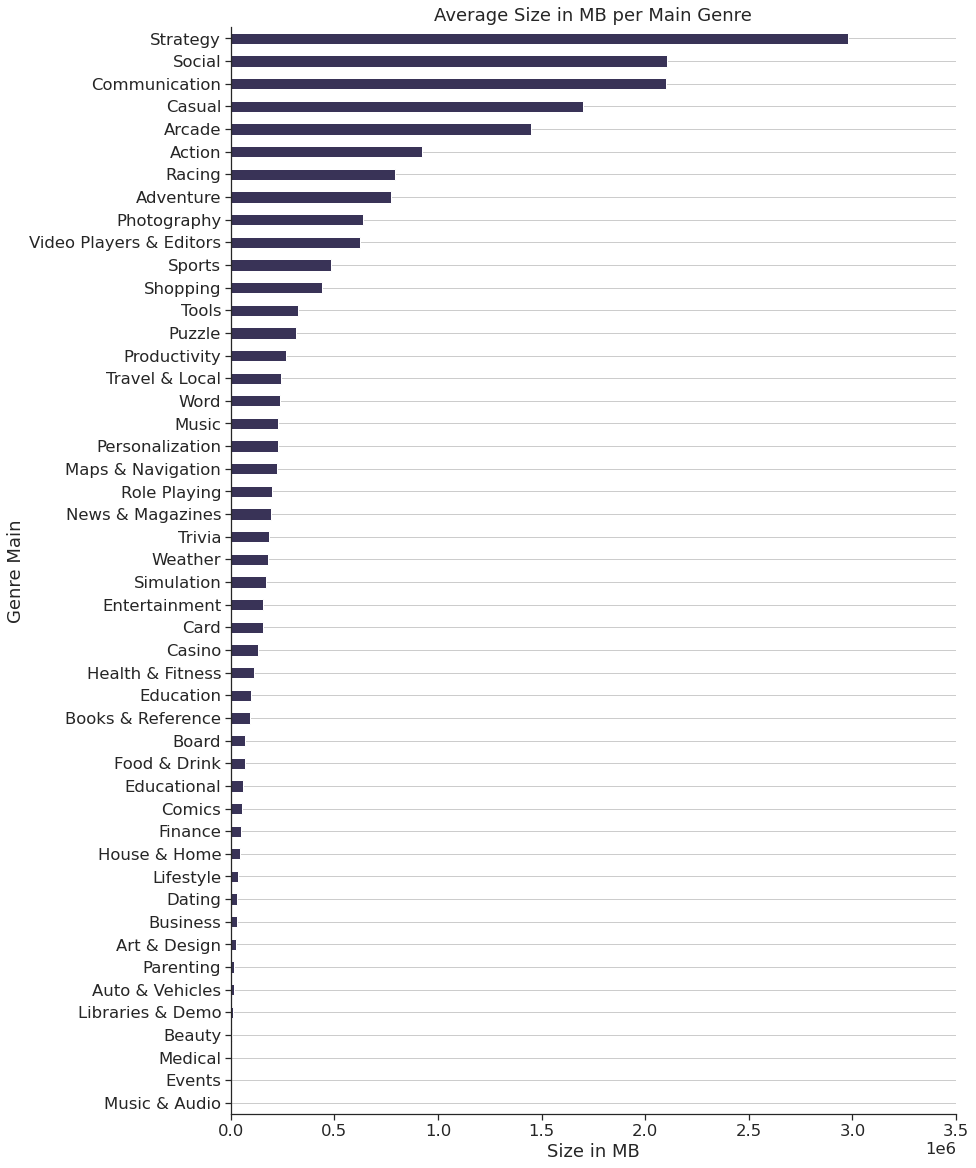

In [78]:
ax = df.groupby('Genre Main').mean()['Reviews'].sort_values().plot(kind='barh', figsize=(13,20))
ax.set_title('Average Size in MB per Main Genre')
ax.set_xlabel('Size in MB')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.grid(axis='y')

## Average Size in MB by Sub Genre

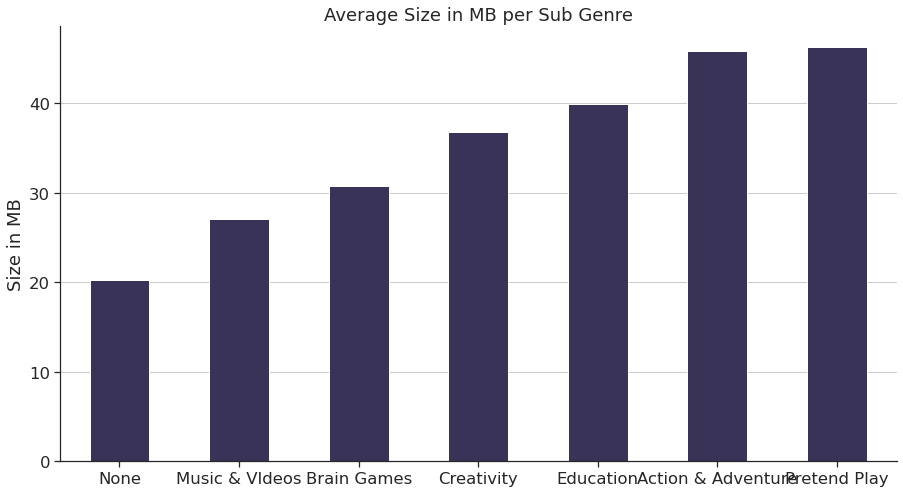

In [79]:
ax = df.groupby('Genre Sub').mean()['Size in MB'].sort_values().plot(kind='bar', figsize=(15,8))
ax.set_title('Average Size in MB per Sub Genre')
ax.set_xlabel('')
ax.set_ylabel('Size in MB')
ax.set_xticks(ax.get_xticks()) # added this to supress FixedFormatter warning 
ax.xaxis.set_ticklabels(['None', 'Music & VIdeos', 'Brain Games', 
                         'Creativity', 'Education','Action & Adventure',
                         'Pretend Play'], rotation='horizontal');ax.grid(axis='y')

## Type by Installs

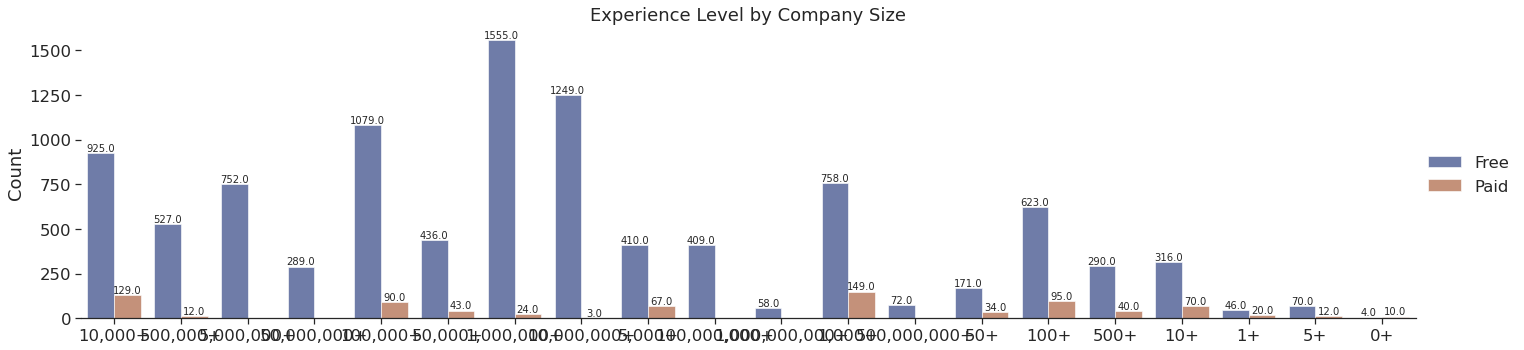

In [80]:
g = sns.catplot(data=df, 
                kind='count',
                x='Installs',
                hue='Type',
                ci='sd',
                palette='dark',
                alpha=.6,
                height=5,
                aspect=4)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

ax = g.facet_axis(0, 0)
ax.set_title('Experience Level by Company Size')

for c in ax.containers:
    labels = [f'{v.get_height()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Type by Content Rating

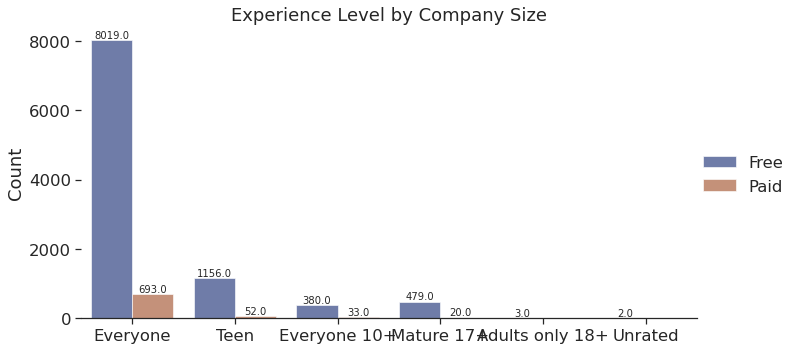

In [81]:
g = sns.catplot(data=df, 
                kind='count',
                x='Content Rating',
                hue='Type',
                ci='sd',
                palette='dark',
                alpha=.6,
                height=5,
                aspect=2)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

ax = g.facet_axis(0, 0)
ax.set_title('Experience Level by Company Size')

for c in ax.containers:
    labels = [f'{v.get_height()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Type by Category

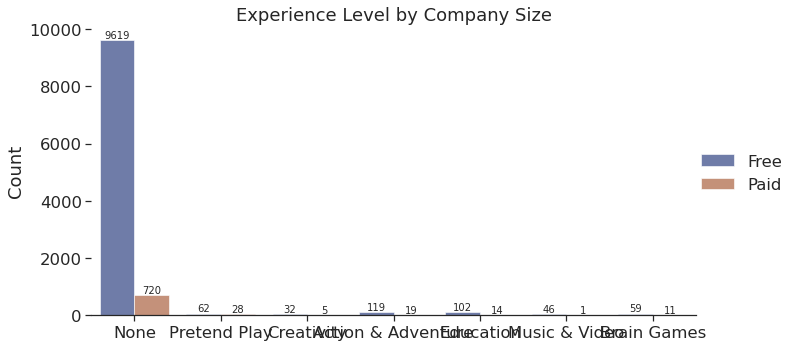

In [82]:
g = sns.catplot(data=df, 
                kind='count',
                x='Genre Sub',
                hue='Type',
                ci='sd',
                palette='dark',
                alpha=.6,
                height=5,
                aspect=2)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

ax = g.facet_axis(0, 0)
ax.set_title('Experience Level by Company Size')

for c in ax.containers:
    labels = [f'{v.get_height()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

## Content Rating by Sub Genre

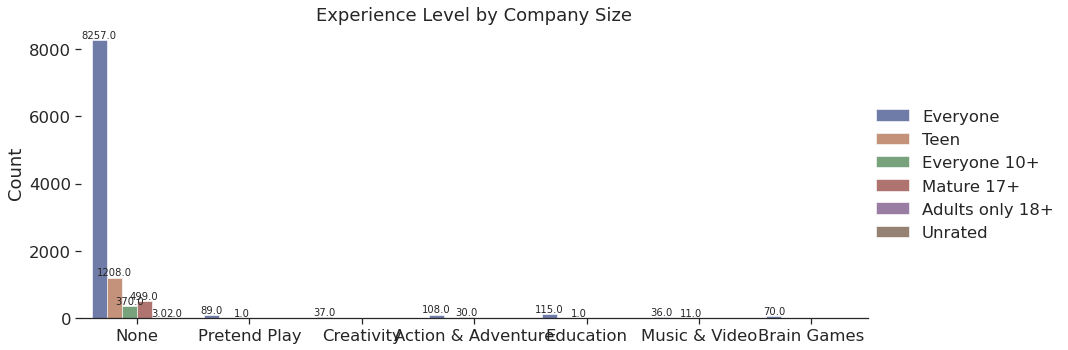

In [83]:
g = sns.catplot(data=df, 
                kind='count',
                x='Genre Sub',
                hue='Content Rating',
                ci='sd',
                palette='dark',
                alpha=.6,
                height=5,
                aspect=2.5)
g.despine(left=True)
g.set_axis_labels("", "Count")
g.legend.set_title("")

ax = g.facet_axis(0, 0)
ax.set_title('Experience Level by Company Size')

for c in ax.containers:
    labels = [f'{v.get_height()}' for v in c]
    ax.bar_label(c, labels=labels, label_type='edge')

# Pricing Distribution

In [89]:
data['Type'].unique(), data.shape

(array(['Free', 'Paid'], dtype=object), (9635, 15))

In [90]:
data[data.Type.isnull()]

Empty DataFrame
Columns: [App_ID, App, Category, Rating, Reviews, Installs, Type, Price, Content Rating, Genres, Last Updated, Genre Main, Genre Sub, Size in MB, Installs_Min]
Index: []

In [91]:
data['Type'].value_counts()

Free    8885
Paid     750
Name: Type, dtype: int64

In [92]:
data.groupby('Type').Price.sum()

Type
Free       0.00
Paid    8922.19
Name: Price, dtype: float64

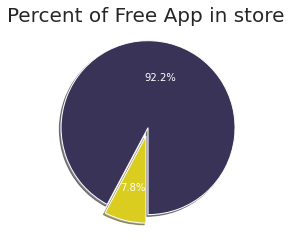

In [94]:
# Data to plot
labels = data['Type'].value_counts(sort = True).index
sizes = data['Type'].value_counts(sort = True)
explode = (0.1,0)  # explode 1st slice
 
# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=[custom_palette[0],custom_palette[2]],
        autopct='%1.1f%%', shadow=True, startangle=270, textprops={'color':'w'})

plt.title('Percent of Free App in store',size = 20)
# plt.legend(loc='best')
plt.show()

## Overall

The Google playstore is dominated by Free apps.

In [96]:
get_outliers(data, 'Price')

IQR: 0.0 -- Lower: 0.0 -- Upper: 0.0


(0.0, 0.0)

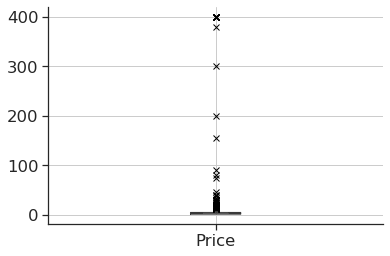

In [97]:
data[data['Price'] > 0][['Price']].boxplot(
    notch=True, showcaps=False,
    flierprops={"marker": "x"},
    # showfliers=False
    # boxprops={"facecolor": (.4, .6, .8, .5)},
    # medianprops={"color": "coral"},
)
plt.show()

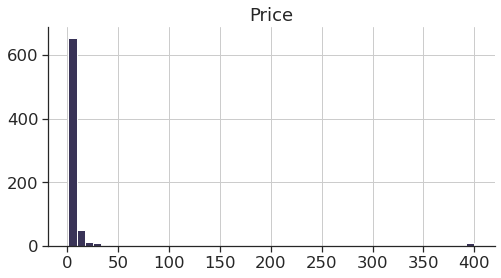

In [98]:
data[data['Price'] > 0][['Price']].hist(layout=(5, 1), figsize=(8, 25), bins=50)
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='price', ylabel='freq'>

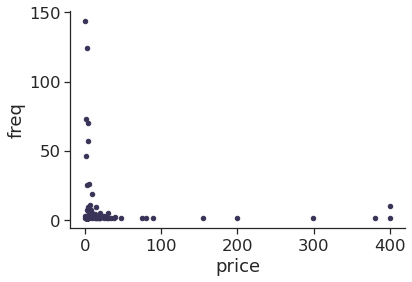

In [99]:
df_plt = data['Price'].value_counts().rename_axis('price').reset_index(name='freq')
df_plt[df_plt.price > 0].plot.scatter(x='price', y='freq')

In [100]:
data['Price'].quantile(0.25)

0.0

In [101]:
data.describe()

App_ID       Rating       Reviews        Price   Size in MB  \
count  9635.000000  9635.000000  9.635000e+03  9635.000000  9635.000000   
mean   4817.000000     4.174958  2.165332e+05     0.926019    20.273482   
std    2781.529256     0.496007  1.832318e+06    14.785303    20.659144   
min       0.000000     1.000000  0.000000e+00     0.000000     0.010000   
25%    2408.500000     4.000000  2.500000e+01     0.000000     5.300000   
50%    4817.000000     4.210000  9.740000e+02     0.000000    13.590000   
75%    7225.500000     4.500000  2.945350e+04     0.000000    27.000000   
max    9634.000000     5.000000  7.812821e+07   400.000000   100.000000   

       Installs_Min  
count  9.635000e+03  
mean   7.783141e+06  
std    5.381585e+07  
min    0.000000e+00  
25%    1.000000e+03  
50%    1.000000e+05  
75%    1.000000e+06  
max    1.000000e+09

## Paid apps

In [103]:
df_paid_apps = data.loc[data['Price'] > 0]
df_paid_apps.shape

(750, 15)

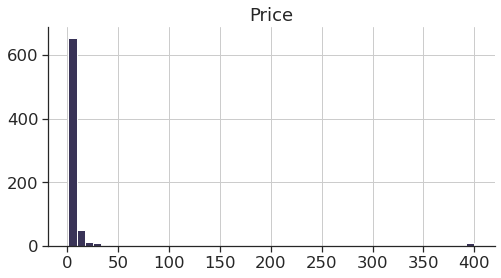

In [104]:
df_paid_apps[['Price']].hist(layout=(5, 1), figsize=(8, 25), bins=50)
plt.show()

In [105]:
df_paid_apps.describe()

App_ID      Rating       Reviews       Price  Size in MB  \
count   750.000000  750.000000  7.500000e+02  750.000000  750.000000   
mean   5200.008000    4.258533  8.787844e+03   11.896253   18.932560   
std    2398.971767    0.506475  9.019943e+04   51.779595   21.448213   
min     233.000000    1.000000  0.000000e+00    0.990000    0.010000   
25%    3507.500000    4.170000  6.000000e+00    1.490000    3.300000   
50%    5066.000000    4.300000  8.800000e+01    2.990000   11.000000   
75%    7178.750000    4.600000  1.215250e+03    4.990000   27.210000   
max    9592.000000    5.000000  2.375336e+06  400.000000  100.000000   

       Installs_Min  
count  7.500000e+02  
mean   7.633304e+04  
std    5.411052e+05  
min    0.000000e+00  
25%    1.000000e+02  
50%    1.000000e+03  
75%    1.000000e+04  
max    1.000000e+07

### A. Paid apps - Outliers

In [106]:
paid_lowerlim, paid_upperlim = get_outliers(df_paid_apps, 'Price')
df_paid_belowlim = df_paid_apps[(df_paid_apps.Price < paid_lowerlim)]
df_paid_abovelim = df_paid_apps[(df_paid_apps.Price > paid_upperlim)]
df_paid_valid = df_paid_apps[(df_paid_apps.Price > paid_lowerlim) & (df_paid_apps.Price < paid_upperlim)]

print(f'Total paid apps:{df_paid_apps.shape} -- Below lower limit: {df_paid_belowlim.shape} \
-- Beyond upper limit: {df_paid_abovelim.shape} \
-- Within valid range: {df_paid_valid.shape}')

IQR: 3.5 -- Lower: -3.76 -- Upper: 10.24
Total paid apps:(750, 15) -- Below lower limit: (0, 15) -- Beyond upper limit: (69, 15) -- Within valid range: (681, 15)


<b> 20 Highest-priced apps - Beyond the upper IQR range limit
    
1. Duplicated entries of the same app but different names
2. Oddly-named apps
3. (Limitation) Unstandardized app names

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25105 (\N{CJK UNIFIED IDEOGRAPH-6211}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24456 (\N{CJK UNIFIED IDEOGRAPH-5F88}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37666 (\N{CJK UNIFIED IDEOGRAPH-9322}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


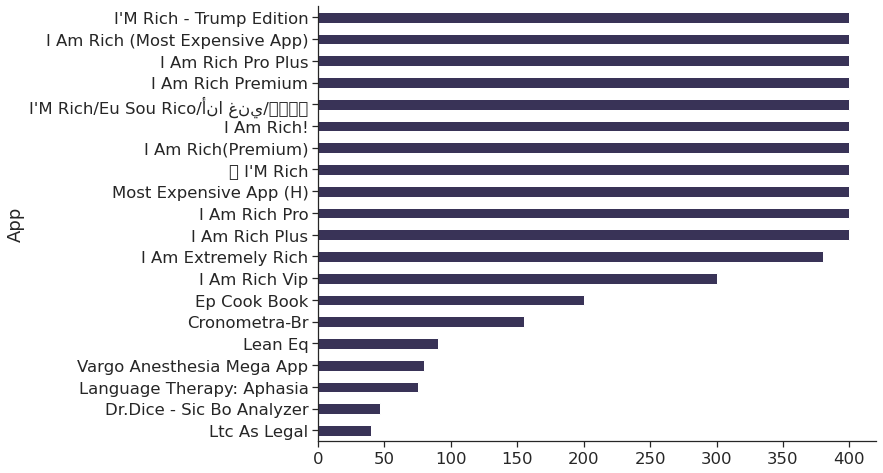

In [107]:
df_plt = df_paid_abovelim.sort_values('Price', ascending=False)
df_plt.nlargest(20, 'Price').plot.barh(x='App', y='Price', figsize=(10, 8), legend=False)
plt.gca().invert_yaxis()
plt.show()

### B. Paid apps - Valid range

<b> Normal app price is less than \\$10. Majority of the priced apps in the dataset is less than \\$2 <b>

In [108]:
count, bins = np.histogram(df_paid_valid[['Price']])

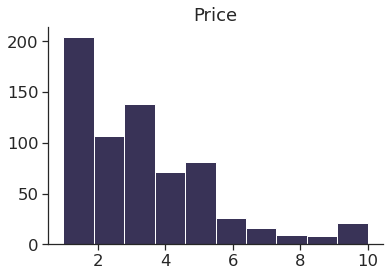

In [109]:
df_paid_valid[['Price']].hist(grid=False)
plt.show()

<b> Books and Reference, Parenting, and Business-related apps have the highest median price ($) <b>

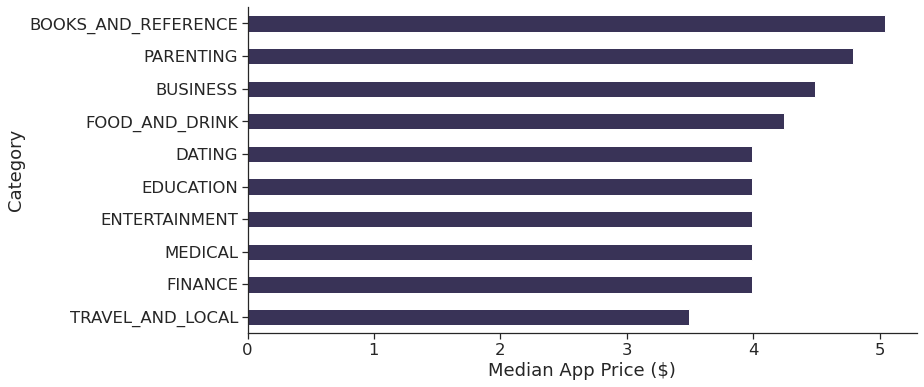

In [110]:
df_plt = df_paid_valid.groupby('Category').Price.median().sort_values(ascending=False).reset_index()
df_plt.nlargest(10, 'Price').plot.barh(x='Category', y='Price', figsize=(12, 6), legend=False)
plt.xlabel('Median App Price ($)')
plt.gca().invert_yaxis()
plt.show()

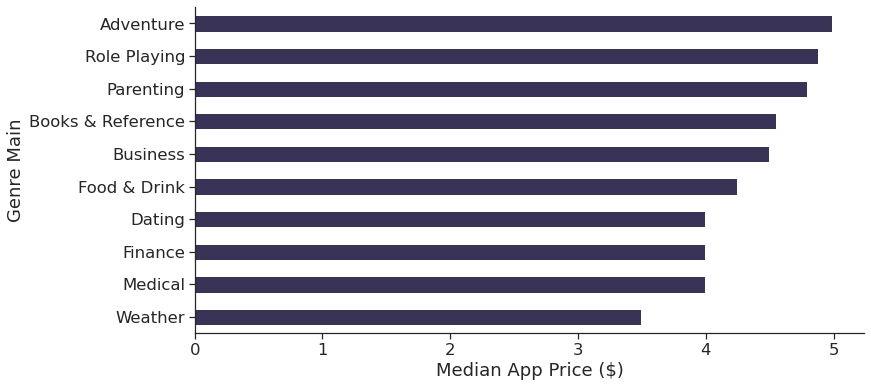

In [111]:
df_plt = df_paid_valid.groupby('Genre Main').Price.median().sort_values(ascending=False).reset_index()
df_plt.nlargest(10, 'Price').plot.barh(x='Genre Main', y='Price', figsize=(12, 6), legend=False)
plt.xlabel('Median App Price ($)')
plt.gca().invert_yaxis()
plt.show()

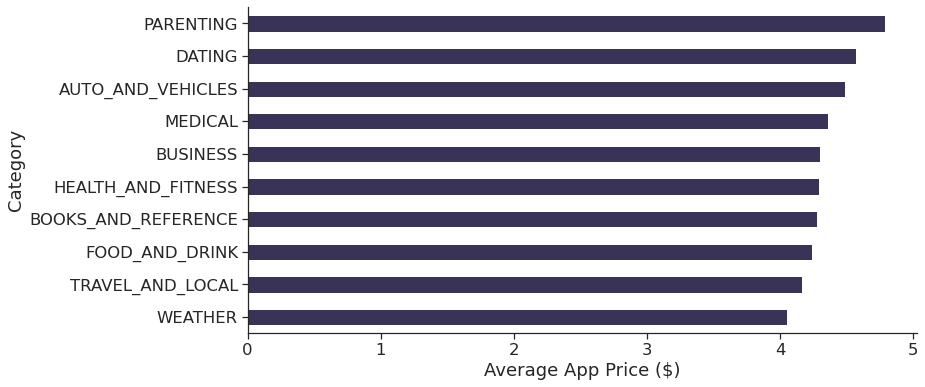

In [112]:
df_plt = df_paid_valid.groupby('Category').Price.mean().sort_values(ascending=False).reset_index()
df_plt.nlargest(10, 'Price').plot.barh(x='Category', y='Price', figsize=(12, 6), legend=False)
plt.xlabel('Average App Price ($)')
plt.gca().invert_yaxis()
plt.show()

<b> Social media, Personalization, and Video players are the lowest priced apps based on Median <b>

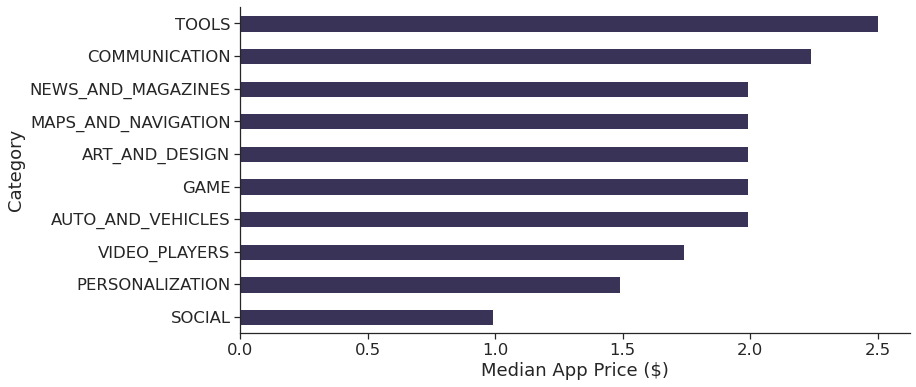

In [113]:
df_plt = df_paid_valid.groupby('Category').Price.median().sort_values(ascending=False).reset_index()
df_plt.nsmallest(10, 'Price').plot.barh(x='Category', y='Price', figsize=(12, 6), legend=False)
plt.xlabel('Median App Price ($)')
plt.show()

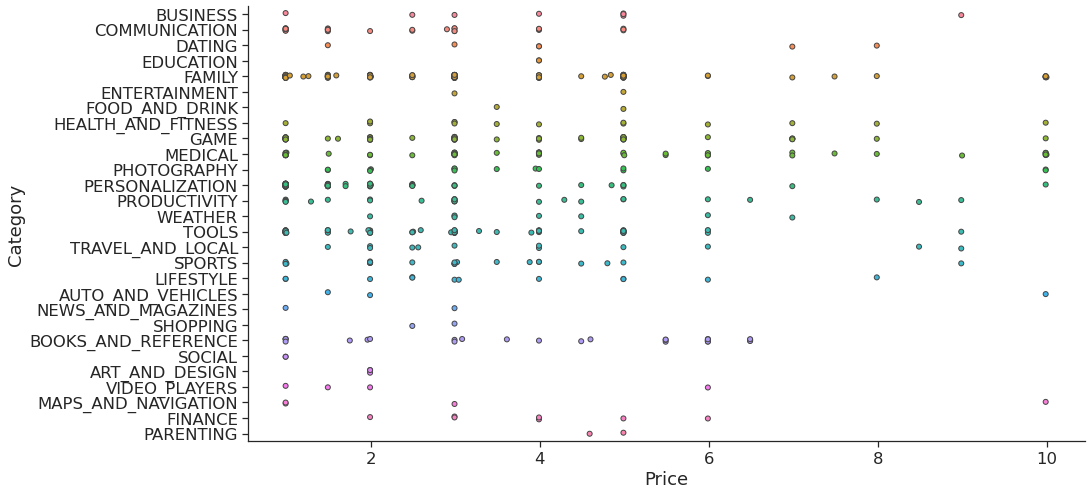

In [114]:
fig = plt.figure(figsize=(5, 20))
fig.set_size_inches(15, 8)
sns.stripplot(x="Price", y="Category", data=df_paid_valid, jitter=True, linewidth=1)
plt.show()

# Price vs. Rating
How does pricing affect user ratings?

In [115]:
data.head()

App_ID                                                App        Category  \
0       0     Photo Editor & Candy Camera & Grid & Scrapbook  ART_AND_DESIGN   
2       1                                Coloring Book Moana          FAMILY   
3       2  U Launcher Lite – Free Live Cool Themes, Hide ...  ART_AND_DESIGN   
4       3                              Sketch - Draw & Paint  ART_AND_DESIGN   
5       4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN   

   Rating  Reviews     Installs  Type  Price Content Rating  \
0     4.1      159      10,000+  Free    0.0       Everyone   
2     3.9      974     500,000+  Free    0.0       Everyone   
3     4.7    87510   5,000,000+  Free    0.0       Everyone   
4     4.5   215644  50,000,000+  Free    0.0           Teen   
5     4.3      967     100,000+  Free    0.0       Everyone   

                      Genres Last Updated    Genre Main     Genre Sub  \
0               Art & Design   2018-01-07  Art & Design          None   
2  Art & Design;Pretend Play   2018-01-15  Art & Design  Pretend Play   
3               Art & Design   2018-08-01  Art & Design          None   
4               Art & Design   2018-06-08  Art & Design          None   
5    Art & Design;Creativity   2018-06-20  Art & Design    Creativity   

   Size in MB  Installs_Min  
0        19.0         10000  
2        14.0        500000  
3         8.7       5000000  
4        25.0      50000000  
5         2.8        100000

## A. Paid vs. Free - Ratings
Overall, no significant difference

In [116]:
data.groupby('Type').Rating.mean()

Type
Free    4.167903
Paid    4.258533
Name: Rating, dtype: float64

In [117]:
data.groupby('Type').Rating.median()

Type
Free    4.2
Paid    4.3
Name: Rating, dtype: float64

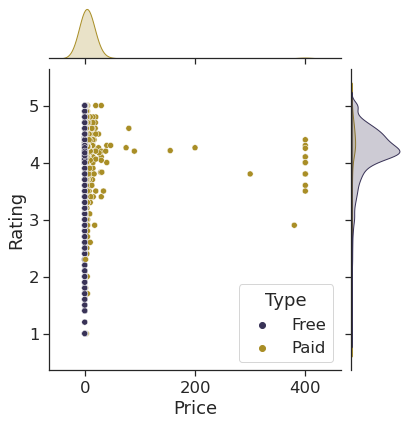

In [118]:
sns.jointplot(data=data, x='Price', y='Rating', hue='Type') #, kind='hex'
plt.show()

In [119]:
df_plt.shape

(28, 2)

Paid apps are usually at have higher than average ratings. However, there's a limit on how much customers are willing to spend on apps as seen by how the ratings get more spread out as the price increases.

In [120]:
data_no_outliers = data[(data.Price > paid_lowerlim) & (data.Price < paid_upperlim)]

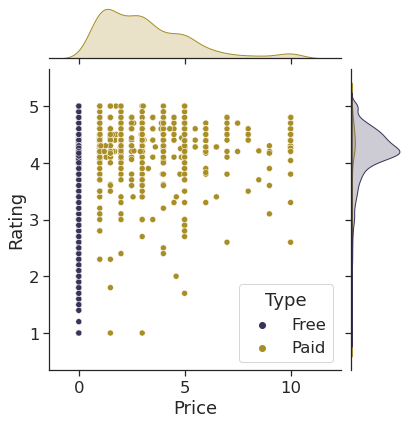

In [121]:
sns.jointplot(data=data_no_outliers, x='Price', y='Rating', hue='Type') #, kind='hex'
plt.show()

## B. Price Categories vs. Ratings

In [124]:
df_paid_valid['Price_Category'] = pd.qcut(df_paid_valid.Price, q=3, labels=['Low', 'Average', 'High'])

/tmp/ipykernel_597/977770369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paid_valid['Price_Category'] = pd.qcut(df_paid_valid.Price, q=3, labels=['Low', 'Average', 'High'])


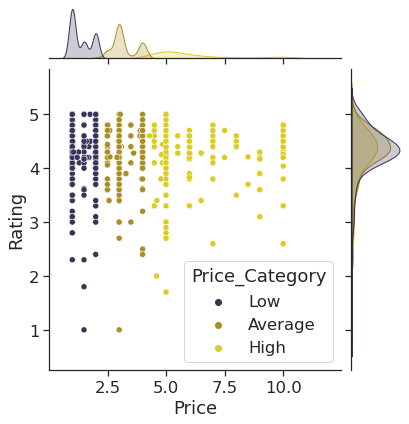

In [125]:
sns.jointplot(data=df_paid_valid, x='Price', y='Rating', hue='Price_Category') #, kind='hex'
plt.show()

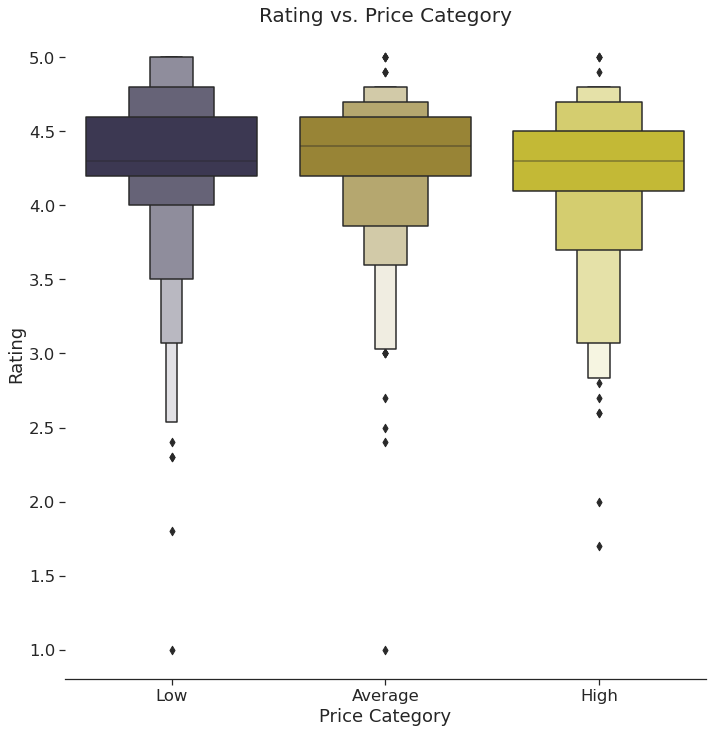

In [126]:
g = sns.catplot(x='Price_Category', y='Rating', data=df_paid_valid, kind="boxen", height = 10)
g.despine(left=True)
g.set_xticklabels()
g.set_ylabels('Rating')
g.set_xlabels('Price Category')
plt.title('Rating vs. Price Category', size = 20)
plt.show()

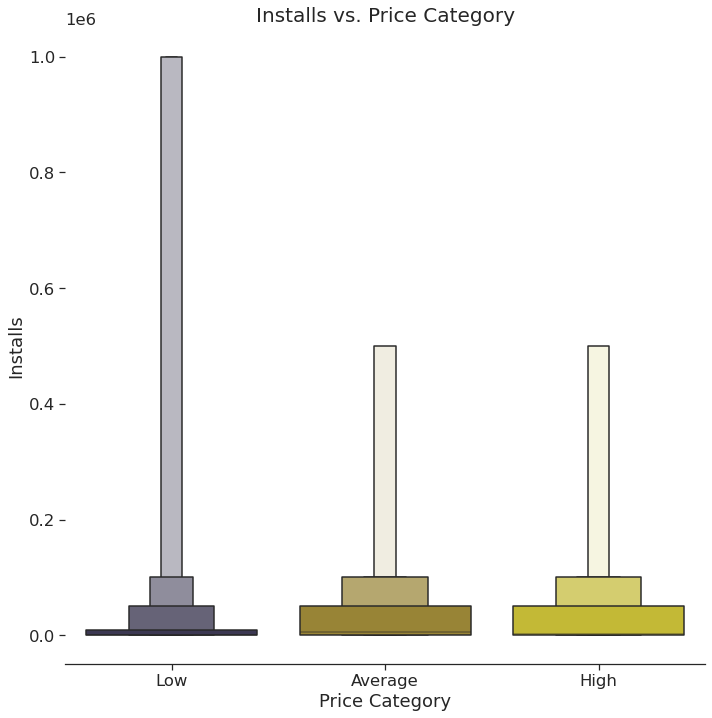

In [127]:
g = sns.catplot(x='Price_Category', y='Installs_Min', data=df_paid_valid, kind="boxen", height = 10, showfliers=False)
g.despine(left=True)
g.set_xticklabels()
g.set_ylabels('Installs')
g.set_xlabels('Price Category')
plt.title('Installs vs. Price Category', size = 20)
plt.show()

In [128]:
# df_plt = df_paid_valid.groupby('Category').Price.median().sort_values(ascending=False).reset_index()
# df_plt.nlargest(10, 'Price').plot.barh(x='Category', y='Price', figsize=(12, 6), legend=False)
# plt.xlabel('Median App Price ($)')
# plt.gca().invert_yaxis()
# plt.show()

# Price vs. Other Dimensions
How does pricing affect user reviews?

How does app size affect pricing?

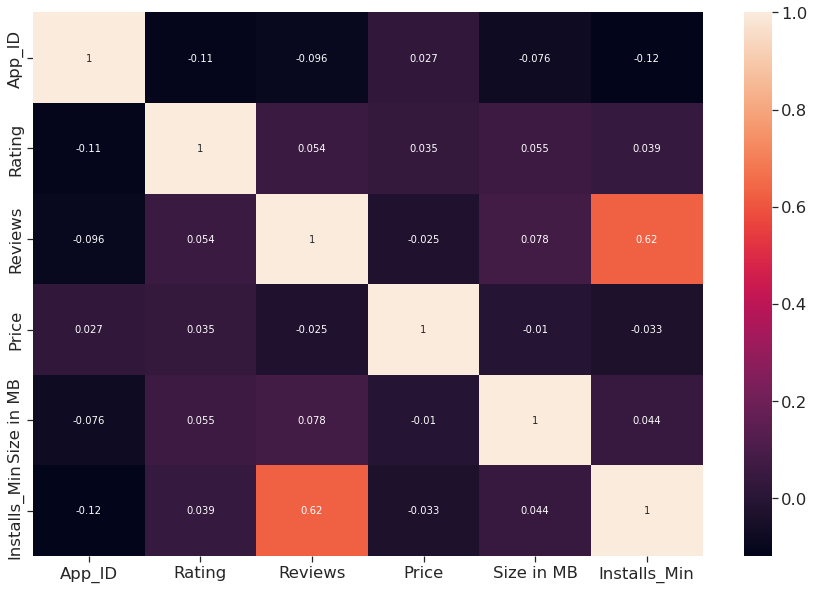

In [133]:
fig, ax = plt.subplots() 
fig.set_size_inches(15,10)
corrmat = data_no_outliers.corr()
#f, ax = plt.subplots()
p = sns.heatmap(corrmat, annot=True)

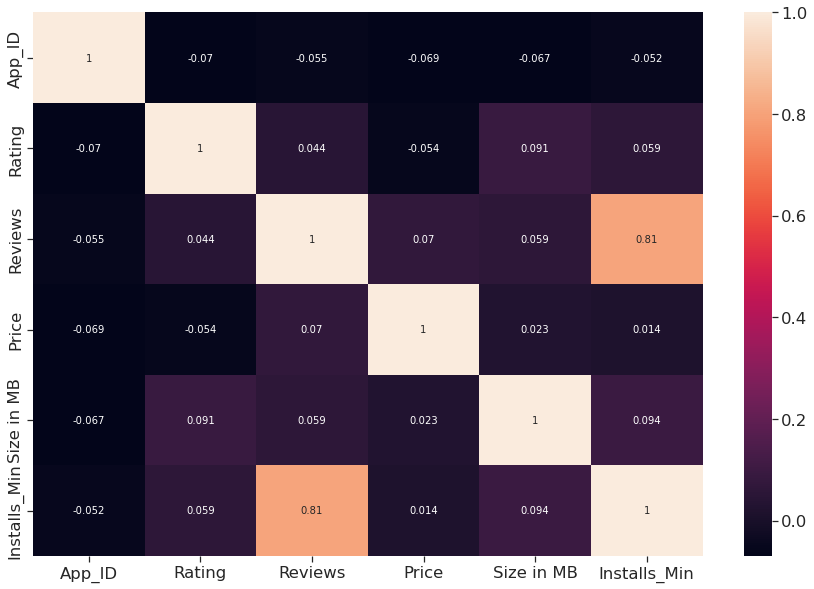

In [135]:
fig, ax = plt.subplots() 
fig.set_size_inches(15,10)
corrmat = df_paid_valid.corr()
#f, ax = plt.subplots()
p = sns.heatmap(corrmat, annot=True)

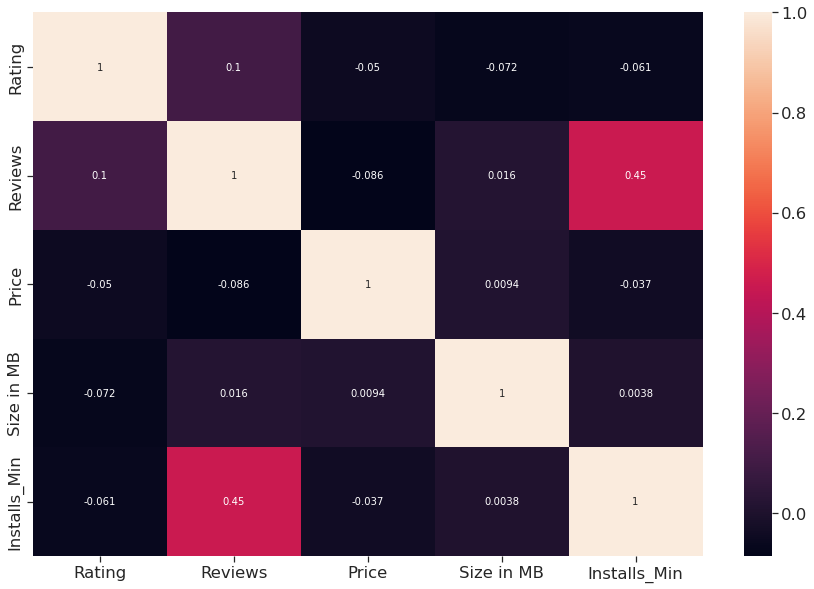

In [137]:
"""
BOOKS AND REFERENCE RELATED APPS (TOP-PRICED)
"""
fig, ax = plt.subplots() 
fig.set_size_inches(15,10)

cols = ['Rating', 'Reviews', 'Price', 'Size in MB', 'Installs_Min']
corrmat = data_no_outliers.loc[data_no_outliers.Category == 'BOOKS_AND_REFERENCE'][cols].corr()
#f, ax = plt.subplots()
p = sns.heatmap(corrmat, annot=True)

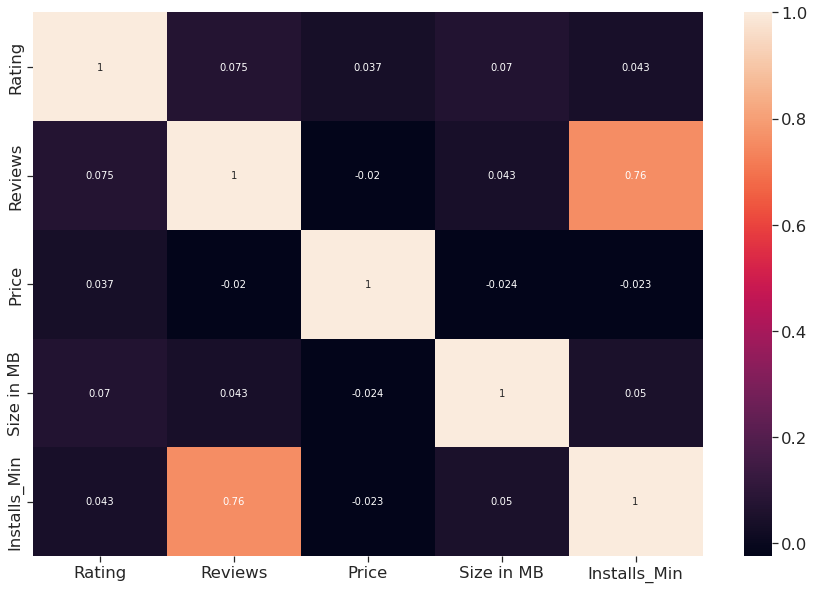

In [138]:
"""
BUSINESS RELATED APPS (TOP-PRICED)
"""
fig, ax = plt.subplots() 
fig.set_size_inches(15,10)

cols = ['Rating', 'Reviews', 'Price', 'Size in MB', 'Installs_Min']
corrmat = data_no_outliers.loc[data_no_outliers.Category == 'BUSINESS'][cols].corr()
#f, ax = plt.subplots()
p = sns.heatmap(corrmat, annot=True)

# Additional Info

## Category

In [140]:
data.groupby('Category').agg({'Rating' : np.mean, 'Price': np.median}).sort_values('Rating', ascending=False).nlargest(10, 'Rating')

Rating  Price
Category                            
EVENTS               4.436825    0.0
ART_AND_DESIGN       4.358689    0.0
EDUCATION            4.353654    0.0
BOOKS_AND_REFERENCE  4.339865    0.0
PERSONALIZATION      4.333021    0.0
PARENTING            4.306667    0.0
BEAUTY               4.278868    0.0
HEALTH_AND_FITNESS   4.247944    0.0
SOCIAL               4.246862    0.0
GAME                 4.245297    0.0

In [141]:
data.groupby('App').agg({'Rating' : np.mean, 'Price': np.median}).sort_values('Rating', ascending=False).nlargest(10, 'Rating')

Rating  Price
App                                         
Dine In Ct - Food Delivery        5.0   0.00
Safe Santa Fe                     5.0   0.00
Clinic Doctor Ehr                 5.0   0.00
Cloud Dx Connected Health         5.0   0.00
Awake Dating                      5.0   0.00
Retro Shocked Dw-6000             5.0   1.49
Cn Resident                       5.0   0.00
Gkpb Fp Online Church             5.0   0.00
Color Cl                          5.0   0.00
Accounting Quiz (Aq) Malaysia     5.0   0.00

## Main Genre

In [143]:
data.groupby('Genre Main').agg({'Rating' : np.mean, 'Price': np.median}).sort_values('Rating', ascending=False).nlargest(10, 'Rating')

Rating  Price
Genre Main                        
Events             4.436825    0.0
Art & Design       4.347077    0.0
Puzzle             4.346901    0.0
Books & Reference  4.338444    0.0
Word               4.338261    0.0
Personalization    4.333021    0.0
Parenting          4.306667    0.0
Music & Audio      4.300000    0.0
Board              4.297119    0.0
Casino             4.286154    0.0

## Installs

In [144]:
data.groupby('Category').Installs_Min.mean().sort_values(ascending=False)

Category
COMMUNICATION          3.504215e+07
VIDEO_PLAYERS          2.403069e+07
SOCIAL                 2.296179e+07
PHOTOGRAPHY            1.666307e+07
PRODUCTIVITY           1.547618e+07
TRAVEL_AND_LOCAL       1.321866e+07
GAME                   1.180261e+07
TOOLS                  9.588801e+06
NEWS_AND_MAGAZINES     9.327629e+06
ENTERTAINMENT          8.970380e+06
BOOKS_AND_REFERENCE    7.504367e+06
SHOPPING               6.932420e+06
FAMILY                 4.615111e+06
WEATHER                4.570893e+06
PERSONALIZATION        4.094906e+06
SPORTS                 3.964754e+06
HEALTH_AND_FITNESS     3.951298e+06
MAPS_AND_NAVIGATION    3.841846e+06
FOOD_AND_DRINK         1.908096e+06
ART_AND_DESIGN         1.856362e+06
EDUCATION              1.802413e+06
BUSINESS               1.663876e+06
LIFESTYLE              1.368814e+06
FINANCE                1.331268e+06
HOUSE_AND_HOME         1.313682e+06
DATING                 8.241293e+05
COMICS                 8.032348e+05
LIBRARIES_AND_DEMO 

In [145]:
data.shape

(9635, 15)

# Sentiment

In [167]:
df_r = df_review .copy()
df_a = df.copy()

df_r = df_r[df_r.Translated_Review != 'nan']
df_m = df_r.merge(df_a, left_on='App', right_on='App')
display(df_r)
display(df_a)
display(df_m)

App  \
0            10 Best Foods for You   
1            10 Best Foods for You   
2            10 Best Foods for You   
3            10 Best Foods for You   
4            10 Best Foods for You   
...                            ...   
64290  Houzz Interior Design Ideas   
64291  Houzz Interior Design Ideas   
64292  Houzz Interior Design Ideas   
64293  Houzz Interior Design Ideas   
64294  Houzz Interior Design Ideas   

                                       Translated_Review Sentiment  \
0      I like eat delicious food. That's I'm cooking ...  Positive   
1        This help eating healthy exercise regular basis  Positive   
2                                                    NaN       NaN   
3             Works great especially going grocery store  Positive   
4                                           Best idea us  Positive   
...                                                  ...       ...   
64290                                                NaN       NaN   
64291                                                NaN       NaN   
64292                                                NaN       NaN   
64293                                                NaN       NaN   
64294                                                NaN       NaN   

       Sentiment_Polarity  Sentiment_Subjectivity  
0                    1.00                0.533333  
1                    0.25                0.288462  
2                     NaN                     NaN  
3                    0.40                0.875000  
4                    1.00                0.300000  
...                   ...                     ...  
64290                 NaN                     NaN  
64291                 NaN                     NaN  
64292                 NaN                     NaN  
64293                 NaN                     NaN  
64294                 NaN                     NaN  

[64295 rows x 5 columns]

App             Category  \
0         Photo Editor & Candy Camera & Grid & Scrapbook       ART_AND_DESIGN   
1                                    Coloring Book Moana       ART_AND_DESIGN   
2      U Launcher Lite – Free Live Cool Themes, Hide ...       ART_AND_DESIGN   
3                                  Sketch - Draw & Paint       ART_AND_DESIGN   
4                  Pixel Draw - Number Art Coloring Book       ART_AND_DESIGN   
...                                                  ...                  ...   
10836                                   Sya9A Maroc - Fr               FAMILY   
10837                   Fr. Mike Schmitz Audio Teachings               FAMILY   
10838                             Parkinson Exercices Fr              MEDICAL   
10839                      The Scp Foundation Db Fr Nn5N  BOOKS_AND_REFERENCE   
10840      Ihoroscope - 2018 Daily Horoscope & Astrology            LIFESTYLE   

       Rating  Reviews     Installs  Type  Price Content Rating  \
0        4.10      159      10,000+  Free    0.0       Everyone   
1        3.90      967     500,000+  Free    0.0       Everyone   
2        4.70    87510   5,000,000+  Free    0.0       Everyone   
3        4.50   215644  50,000,000+  Free    0.0           Teen   
4        4.30      967     100,000+  Free    0.0       Everyone   
...       ...      ...          ...   ...    ...            ...   
10836    4.50       38       5,000+  Free    0.0       Everyone   
10837    5.00        4         100+  Free    0.0       Everyone   
10838    4.17        3       1,000+  Free    0.0       Everyone   
10839    4.50      114       1,000+  Free    0.0     Mature 17+   
10840    4.50   398307  10,000,000+  Free    0.0       Everyone   

                          Genres Last Updated         Genre Main  \
0                   Art & Design   2018-01-07       Art & Design   
1      Art & Design;Pretend Play   2018-01-15       Art & Design   
2                   Art & Design   2018-08-01       Art & Design   
3                   Art & Design   2018-06-08       Art & Design   
4        Art & Design;Creativity   2018-06-20       Art & Design   
...                          ...          ...                ...   
10836                  Education   2017-07-25          Education   
10837                  Education   2018-07-06          Education   
10838                    Medical   2017-01-20            Medical   
10839          Books & Reference   2015-01-19  Books & Reference   
10840                  Lifestyle   2018-07-25          Lifestyle   

          Genre Sub  Size in MB  
0              None       19.00  
1      Pretend Play       14.00  
2              None        8.70  
3              None       25.00  
4        Creativity        2.80  
...             ...         ...  
10836          None       53.00  
10837          None        3.60  
10838          None        9.50  
10839          None       13.46  
10840          None       19.00  

[10837 rows x 13 columns]

App  \
0       1800 Contacts - Lens Store   
1       1800 Contacts - Lens Store   
2       1800 Contacts - Lens Store   
3       1800 Contacts - Lens Store   
4       1800 Contacts - Lens Store   
...                            ...   
70585  Houzz Interior Design Ideas   
70586  Houzz Interior Design Ideas   
70587  Houzz Interior Design Ideas   
70588  Houzz Interior Design Ideas   
70589  Houzz Interior Design Ideas   

                                       Translated_Review Sentiment  \
0      Great hassle free way order contacts. Got call...  Positive   
1      Great hassle free way order contacts. Got call...  Positive   
2      It's expensive I expected (I thought I'd savin...  Negative   
3      It's expensive I expected (I thought I'd savin...  Negative   
4      Super fast navigation brand fast/easy checkout...  Positive   
...                                                  ...       ...   
70585                                                NaN       NaN   
70586                                                NaN       NaN   
70587                                                NaN       NaN   
70588                                                NaN       NaN   
70589                                                NaN       NaN   

       Sentiment_Polarity  Sentiment_Subjectivity        Category  Rating  \
0                0.600000                0.775000         MEDICAL     4.7   
1                0.600000                0.775000         MEDICAL     4.7   
2               -0.300000                0.500000         MEDICAL     4.7   
3               -0.300000                0.500000         MEDICAL     4.7   
4                0.266667                0.633333         MEDICAL     4.7   
...                   ...                     ...             ...     ...   
70585                 NaN                     NaN  HOUSE_AND_HOME     4.6   
70586                 NaN                     NaN  HOUSE_AND_HOME     4.6   
70587                 NaN                     NaN  HOUSE_AND_HOME     4.6   
70588                 NaN                     NaN  HOUSE_AND_HOME     4.6   
70589                 NaN                     NaN  HOUSE_AND_HOME     4.6   

       Reviews     Installs  Type  Price Content Rating        Genres  \
0        23160   1,000,000+  Free    0.0       Everyone       Medical   
1        23160   1,000,000+  Free    0.0       Everyone       Medical   
2        23160   1,000,000+  Free    0.0       Everyone       Medical   
3        23160   1,000,000+  Free    0.0       Everyone       Medical   
4        23160   1,000,000+  Free    0.0       Everyone       Medical   
...        ...          ...   ...    ...            ...           ...   
70585   353813  10,000,000+  Free    0.0       Everyone  House & Home   
70586   353799  10,000,000+  Free    0.0       Everyone  House & Home   
70587   353800  10,000,000+  Free    0.0       Everyone  House & Home   
70588   353813  10,000,000+  Free    0.0       Everyone  House & Home   
70589   353813  10,000,000+  Free    0.0       Everyone  House & Home   

      Last Updated    Genre Main Genre Sub  Size in MB  
0       2018-07-27       Medical      None       26.00  
1       2018-07-27       Medical      None       26.00  
2       2018-07-27       Medical      None       26.00  
3       2018-07-27       Medical      None       26.00  
4       2018-07-27       Medical      None       26.00  
...            ...           ...       ...         ...  
70585   2018-08-01  House & Home      None       15.98  
70586   2018-08-01  House & Home      None       15.98  
70587   2018-08-01  House & Home      None       15.98  
70588   2018-08-01  House & Home      None       15.98  
70589   2018-08-01  House & Home      None       15.98  

[70590 rows x 17 columns]

In [168]:
df_g = df_m.groupby(['App','Sentiment'])['Sentiment'].agg(count='count')
display(df_g)

count
App                            Sentiment       
1800 Contacts - Lens Store     Negative      12
                               Neutral       20
                               Positive     128
21-Day Meditation Experience   Negative      20
                               Neutral        4
...                                         ...
Hotwire Hotel & Car Rental App Neutral       11
                               Positive      16
Housing-Real Estate & Property Negative      10
                               Neutral        3
                               Positive       8

[1162 rows x 1 columns]

count
App                                               Category                 
Bowmasters                                        GAME                 1872
Helix Jump                                        GAME                 1638
Candy Crush Saga                                  GAME                 1440
Angry Birds Classic                               GAME                 1365
8 Ball Pool                                       GAME                 1314
Duolingo: Learn Languages Free                    EDUCATION             960
Garena Free Fire                                  GAME                  888
Google Photos                                     PHOTOGRAPHY           764
Bubble Shooter                                    GAME                  725
Duolingo: Learn Languages Free                    FAMILY                720
Block Puzzle                                      GAME                  616
Flow Free                                         GAME                  616
Expedia Hotels, Flights & Car Rental Travel Deals TRAVEL_AND_LOCAL      512
Candy Crush Soda Saga                             GAME                  498
Clash Royale                                      GAME                  495
Adobe Acrobat Reader                              PRODUCTIVITY          486
Badoo - Free Chat & Dating App                    SOCIAL                480
Groupon - Shop Deals, Discounts & Coupons         SHOPPING              480
Google Keep                                       PRODUCTIVITY          480
Google News                                       NEWS_AND_MAGAZINES    468

<AxesSubplot:ylabel='App'>

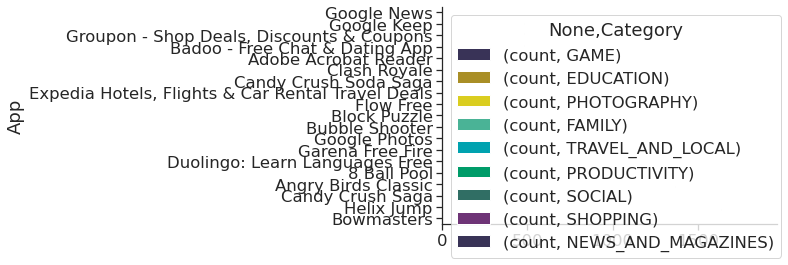

In [169]:
df_g = df_m.groupby(['App','Category'])['Sentiment'].agg(count='count').sort_values(by='count', ascending = False).head(20)
display(df_g)
df_g.unstack().plot.barh()

count
App                                       Category                 
Helix Jump                                GAME                 1254
Bowmasters                                GAME                 1014
Duolingo: Learn Languages Free            EDUCATION             800
8 Ball Pool                               GAME                  624
Angry Birds Classic                       GAME                  620
Candy Crush Saga                          GAME                  612
Duolingo: Learn Languages Free            FAMILY                600
Google Photos                             PHOTOGRAPHY           572
Garena Free Fire                          GAME                  544
Bubble Shooter                            GAME                  500
Flow Free                                 GAME                  404
Groupon - Shop Deals, Discounts & Coupons SHOPPING              380
Adobe Acrobat Reader                      PRODUCTIVITY          357
Calorie Counter - Macros                  HEALTH_AND_FITNESS    348
Hangouts                                  COMMUNICATION         344
Block Puzzle                              GAME                  332
Google Keep                               PRODUCTIVITY          324
Google Pay                                FINANCE               324
Clash Royale                              GAME                  321
Crunchyroll - Everything Anime            ENTERTAINMENT         315

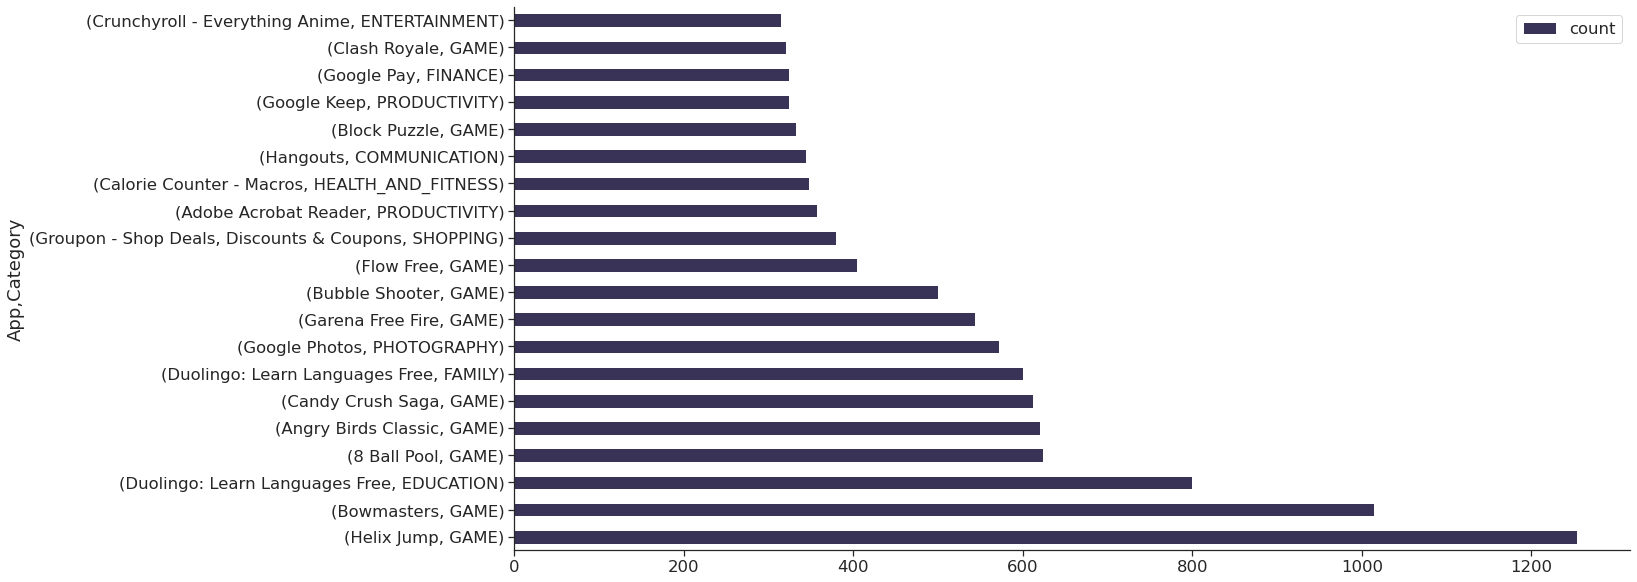

In [171]:
df_g = df_m[df_m.Sentiment == 'Positive'].groupby(['App','Category'])['Sentiment'].agg(count='count', ).sort_values(by='count', ascending = False).head(20)
display(df_g)
df_g.plot(kind='barh', figsize=(20,10))
plt.show()

count
App                                                Category                 
Candy Crush Saga                                   GAME                  756
Angry Birds Classic                                GAME                  735
Bowmasters                                         GAME                  714
8 Ball Pool                                        GAME                  636
Helix Jump                                         GAME                  348
Garena Free Fire                                   GAME                  324
Candy Crush Soda Saga                              GAME                  288
Block Puzzle                                       GAME                  284
Expedia Hotels, Flights & Car Rental Travel Deals  TRAVEL_AND_LOCAL      220
Bubble Shooter                                     GAME                  200
Flow Free                                          GAME                  196
Google Photos                                      PHOTOGRAPHY           188
Clash Royale                                       GAME                  174
Farm Heroes Saga                                   GAME                  172
Cooking Fever                                      GAME                  158
Google News                                        NEWS_AND_MAGAZINES    156
Gyft - Mobile Gift Card Wallet                     SHOPPING              144
Duolingo: Learn Languages Free                     EDUCATION             136
Galaxy Attack: Alien Shooter                       GAME                  129
Fox News – Breaking News, Live Video & News Alerts NEWS_AND_MAGAZINES    126

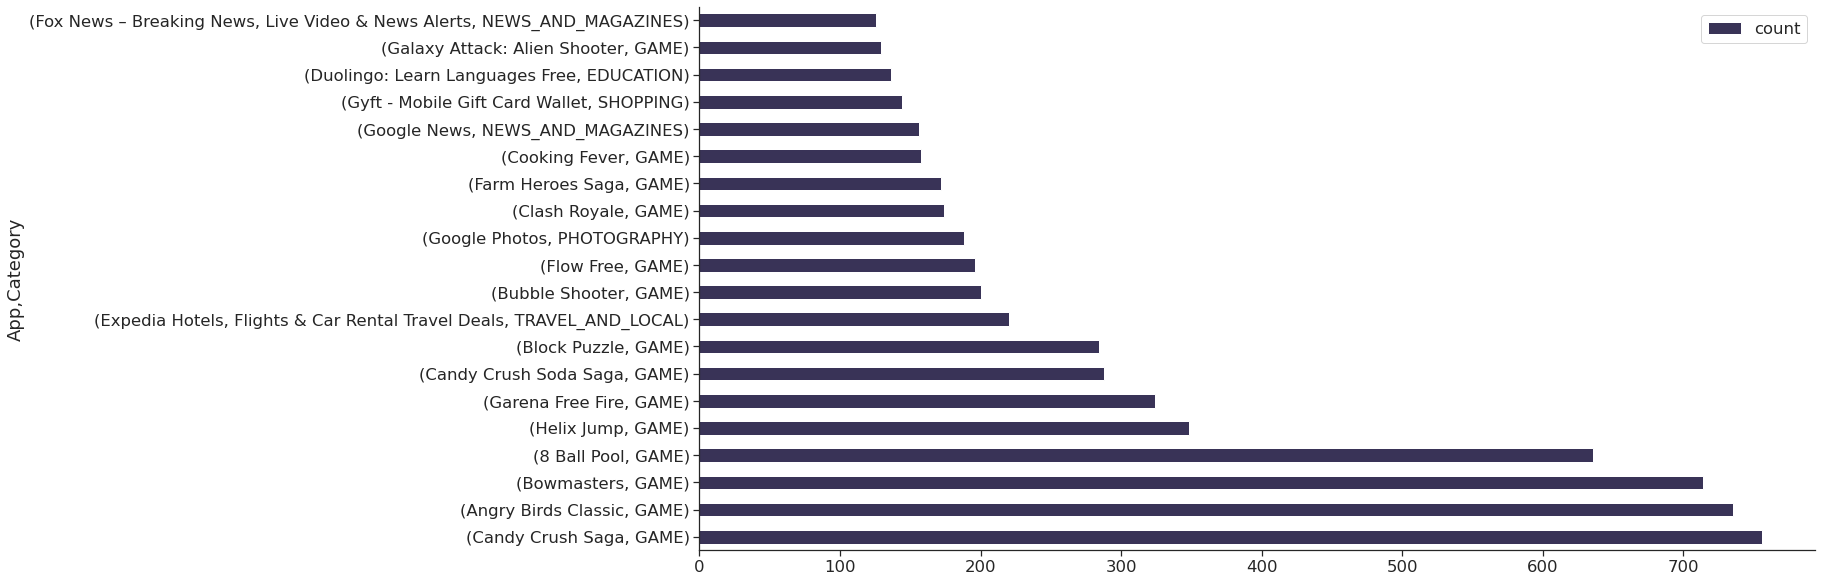

In [173]:
df_g = df_m[df_m.Sentiment == 'Negative'].groupby(['App','Category'])['Sentiment'].agg(count='count', ).sort_values(by='count', ascending = False).head(20)
display(df_g)
df_g.plot(kind='barh', figsize=(20,10))
plt.show()

count
Category                  
GAME                  9286
FAMILY                2529
HEALTH_AND_FITNESS    1304
PHOTOGRAPHY           1184
EDUCATION             1131
PRODUCTIVITY          1111
MEDICAL               1105
TRAVEL_AND_LOCAL       973
SHOPPING               941
FINANCE                884
BUSINESS               874
DATING                 743
COMMUNICATION          716
ENTERTAINMENT          666
NEWS_AND_MAGAZINES     589
PERSONALIZATION        585
SOCIAL                 579
SPORTS                 507
BOOKS_AND_REFERENCE    422
TOOLS                  404

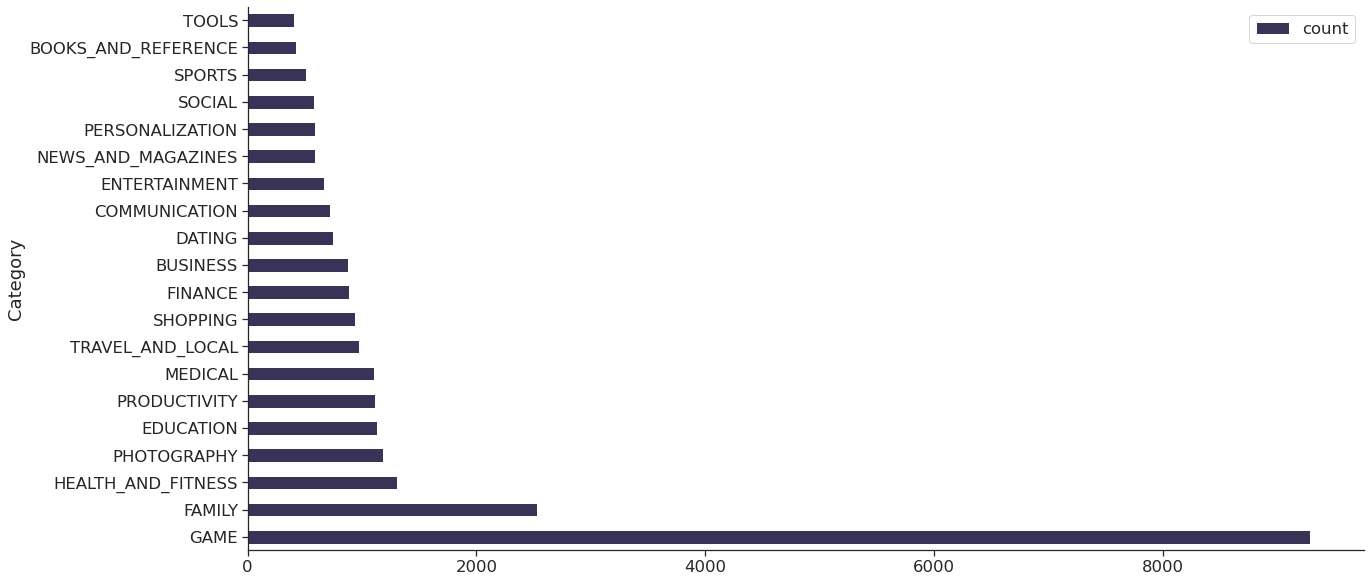

In [175]:
df_g = df_m[df_m.Sentiment == 'Positive'].groupby(['Category'])['Sentiment'].agg(count='count', ).sort_values(by='count', ascending = False).head(20)
display(df_g)
df_g.plot(kind='barh', figsize=(20,10))
plt.show()

count
Category                  
GAME                  6340
FAMILY                1116
TRAVEL_AND_LOCAL       497
SOCIAL                 332
PHOTOGRAPHY            328
SPORTS                 327
NEWS_AND_MAGAZINES     319
FINANCE                306
PRODUCTIVITY           304
SHOPPING               296
DATING                 271
MEDICAL                244
COMMUNICATION          225
BUSINESS               212
ENTERTAINMENT          189
HEALTH_AND_FITNESS     187
EDUCATION              183
PERSONALIZATION        156
LIFESTYLE              103
BOOKS_AND_REFERENCE    102

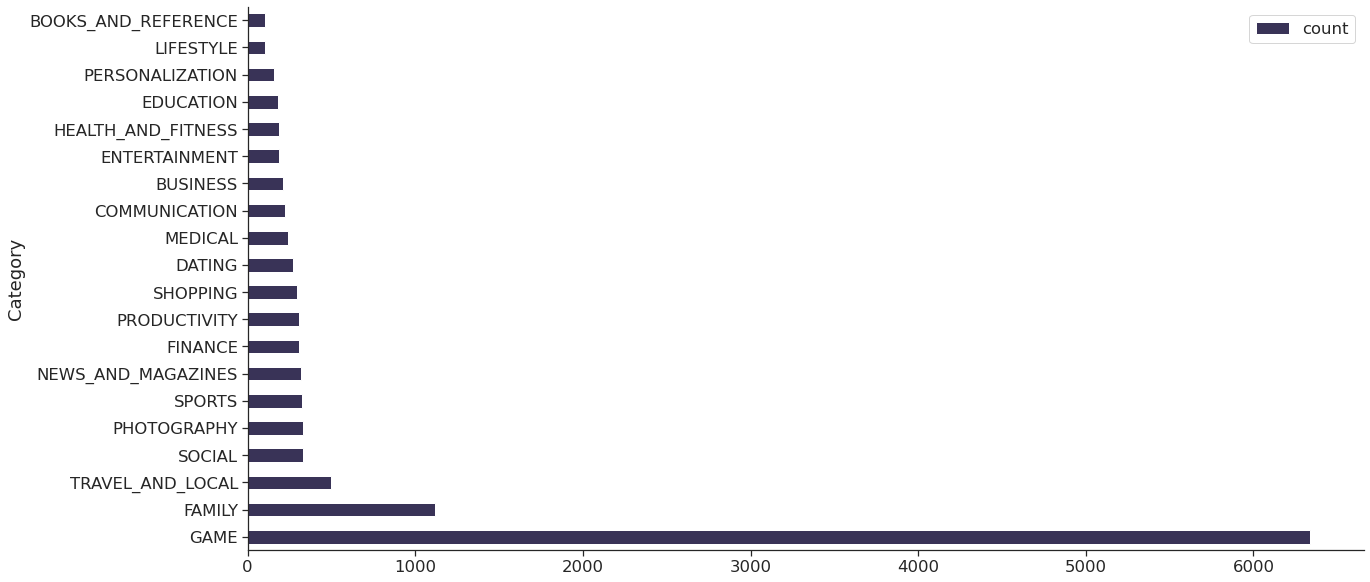

In [177]:
df_g = df_m[df_m.Sentiment == 'Negative'].groupby(['Category'])['Sentiment'].agg(count='count').sort_values(by='count', ascending = False).head(20)
#df_g = df_m[df_m.Sentiment == 'Negative'].groupby(['Category', 'Sentiment'])['Sentiment'].agg(count='count', ).sort_values(by='count').head(20)
display(df_g)
df_g.plot(kind='barh', figsize=(20,10))
plt.show()

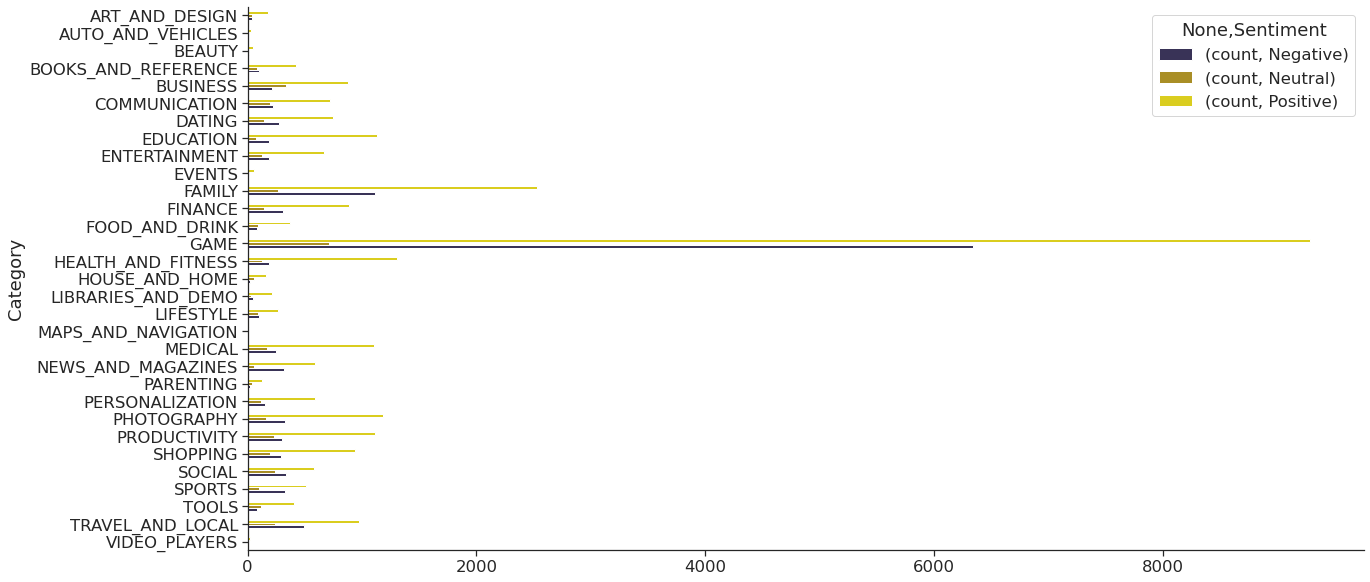

In [179]:
df_g = df_m.groupby(['Category','Sentiment'])['Sentiment'].agg(count='count', ).sort_values(by='Category', ascending = False)

df_g = df_g.unstack()
df_g.plot(kind='barh', figsize=(20,10))
plt.show()

count
Sentiment       
Negative   12300
Neutral     4197
Positive   27657

count
Sentiment       
Negative      51
Neutral       14
Positive     356

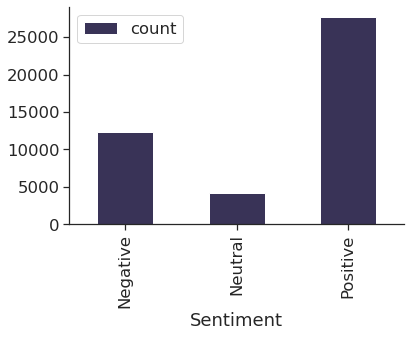

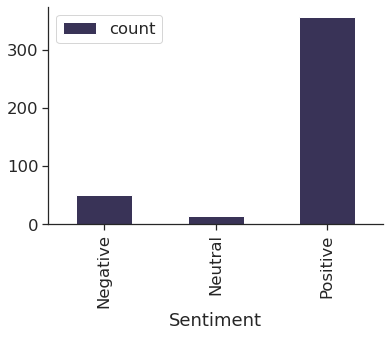

In [180]:
df_g = df_m[df_m.Type == 'Free'].groupby(['Sentiment'])['Sentiment'].agg(count='count')
display(df_g)
df_g.plot.bar()
df_g2 = df_m[df_m.Type == 'Paid'].groupby(['Sentiment'])['Sentiment'].agg(count='count')
display(df_g2)
df_g2.plot.bar()
plt.show()

count
Sentiment       
Negative      51
Neutral       14
Positive     356

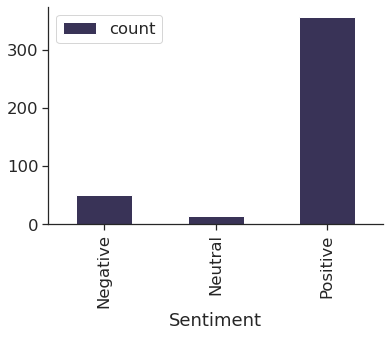

In [181]:
df_g = df_m[df_m.Type == 'Paid'].groupby(['Sentiment'])['Sentiment'].agg(count='count')
display(df_g)
df_g.plot.bar()
plt.show()

In [182]:
dic = {}
for i in df_m[df_m.Sentiment == 'Negative'].Translated_Review.to_numpy():
    x = i.split()
    for i in x:
        i = i.replace('.','')
        i = i.replace(',','')
        i = i.capitalize()
        if dic.get(i) is not None:
            dic[i] += 1
        else:
            dic[i] = 1
            

df_out = pd.DataFrame(dic.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
display(df_out)
df_out.to_csv('negative_words.csv', header=True, index=False, sep=',', mode='w')

Word  Count
2             I  17469
305        Game  10891
77          Get   3228
63           It   3121
226         The   2641
...         ...    ...
7940     Gamble      1
7941    Binding      1
7942  Game-wise      1
7946    Divided      1
9912  Reachable      1

[9913 rows x 2 columns]

In [183]:
dic = {}
for i in df_m[df_m.Sentiment == 'Positive'].Translated_Review.to_numpy():
    x = i.split()
    for i in x:
        i = i.replace('.','')
        i = i.replace(',','')
        i = i.capitalize()
        if dic.get(i) is not None:
            dic[i] += 1
        else:
            dic[i] = 1
            

df_out = pd.DataFrame(dic.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
display(df_out)
df_out.to_csv('positive_words.csv', header=True, index=False, sep=',', mode='w')

Word  Count
38              I  34889
929          Game  10607
77             It   7184
111          Good   5647
44           Love   5579
...           ...    ...
10005      (past)      1
10004  Overallbut      1
9998      Websute      1
9996      Radical      1
17272  Rigorously      1

[17273 rows x 2 columns]

In [184]:
dic = {}
for i in df_m[df_m.Sentiment == 'Neutral'].Translated_Review.to_numpy():
    i = str(i)
    x = i.split()
    for i in x:
        i = i.replace('.','')
        i = i.replace(',','')
        i = i.capitalize()
        if dic.get(i) is not None:
            dic[i] += 1
        else:
            dic[i] = 1
            

df_out = pd.DataFrame(dic.items(), columns=['Word', 'Count']).sort_values(by='Count', ascending=False)
display(df_out)
df_out.to_csv('neutral_words.csv', header=True, index=False, sep=',', mode='w')

Word  Count
10             I   2499
12            It    533
28          Like    394
54           The    383
188         Work    352
...          ...    ...
2646  Categories      1
2645      Breaks      1
2644       00000      1
2643        $646      1
4260     Premise      1

[4261 rows x 2 columns]

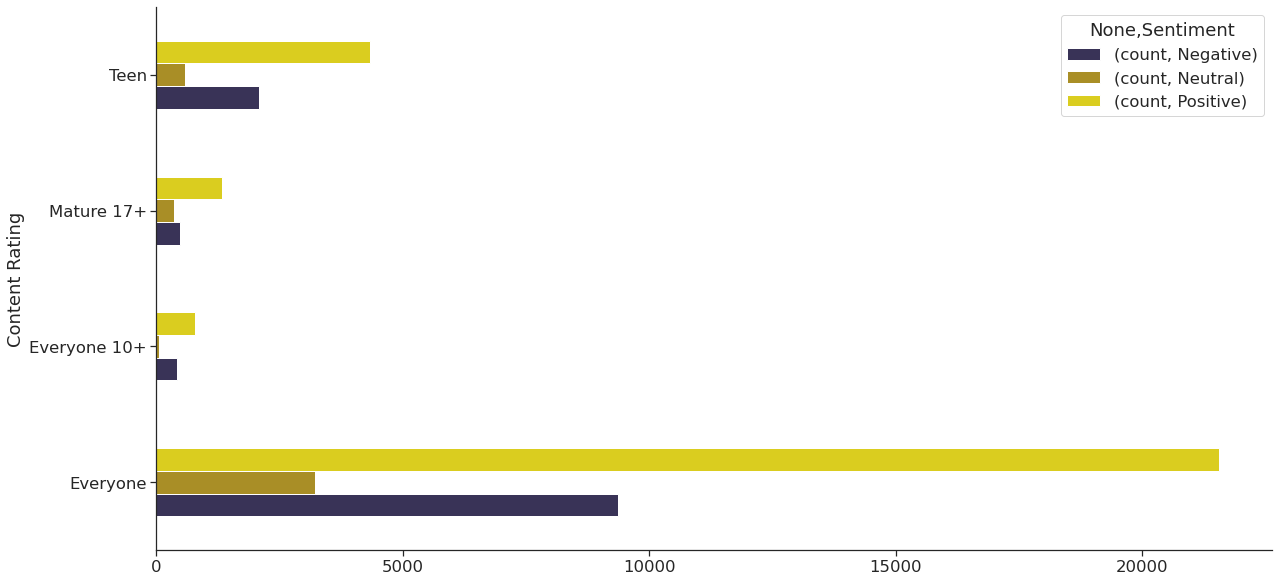

In [185]:
df_g = df_m.groupby(['Content Rating','Sentiment'])['Sentiment'].agg(count='count', ).sort_values(by='Content Rating', ascending = False)

df_g = df_g.unstack()
df_g.plot(kind='barh', figsize=(20,10))
plt.show()

In [186]:
print(df_m)
df_m.to_csv('merge_review_ratings.csv', header=True, index=False, sep=',', mode='w')

                               App  \
0       1800 Contacts - Lens Store   
1       1800 Contacts - Lens Store   
2       1800 Contacts - Lens Store   
3       1800 Contacts - Lens Store   
4       1800 Contacts - Lens Store   
...                            ...   
70585  Houzz Interior Design Ideas   
70586  Houzz Interior Design Ideas   
70587  Houzz Interior Design Ideas   
70588  Houzz Interior Design Ideas   
70589  Houzz Interior Design Ideas   

                                       Translated_Review Sentiment  \
0      Great hassle free way order contacts. Got call...  Positive   
1      Great hassle free way order contacts. Got call...  Positive   
2      It's expensive I expected (I thought I'd savin...  Negative   
3      It's expensive I expected (I thought I'd savin...  Negative   
4      Super fast navigation brand fast/easy checkout...  Positive   
...                                                  ...       ...   
70585                                                

In [193]:
df_g_c = df_m.groupby(['Category','Sentiment']).size().reset_index().rename(columns={0: 'sentiment_count'})
df_g_s = df_g_c.groupby(['Category']).sum().reset_index().rename(columns={'sentiment_count': 'row_count'})

display(df_g_s)


Category  row_count
0        ART_AND_DESIGN        258
1     AUTO_AND_VEHICLES         34
2                BEAUTY         65
3   BOOKS_AND_REFERENCE        607
4              BUSINESS       1426
5         COMMUNICATION       1134
6                DATING       1161
7             EDUCATION       1390
8         ENTERTAINMENT        980
9                EVENTS         57
10               FAMILY       3912
11              FINANCE       1337
12       FOOD_AND_DRINK        547
13                 GAME      16335
14   HEALTH_AND_FITNESS       1621
15       HOUSE_AND_HOME        233
16   LIBRARIES_AND_DEMO        294
17            LIFESTYLE        455
18  MAPS_AND_NAVIGATION         22
19              MEDICAL       1515
20   NEWS_AND_MAGAZINES        968
21            PARENTING        185
22      PERSONALIZATION        862
23          PHOTOGRAPHY       1670
24         PRODUCTIVITY       1647
25             SHOPPING       1435
26               SOCIAL       1149
27               SPORTS        932
28                TOOLS        604
29     TRAVEL_AND_LOCAL       1706
30        VIDEO_PLAYERS         34

In [194]:
df_g_c = df_g_c.merge(df_g_s, left_on='Category', right_on='Category')
df_g_c['pct_sentiment'] = (df_g_c.sentiment_count / df_g_c.row_count) * 100


# Multivariate Analysis

## Pair Plot

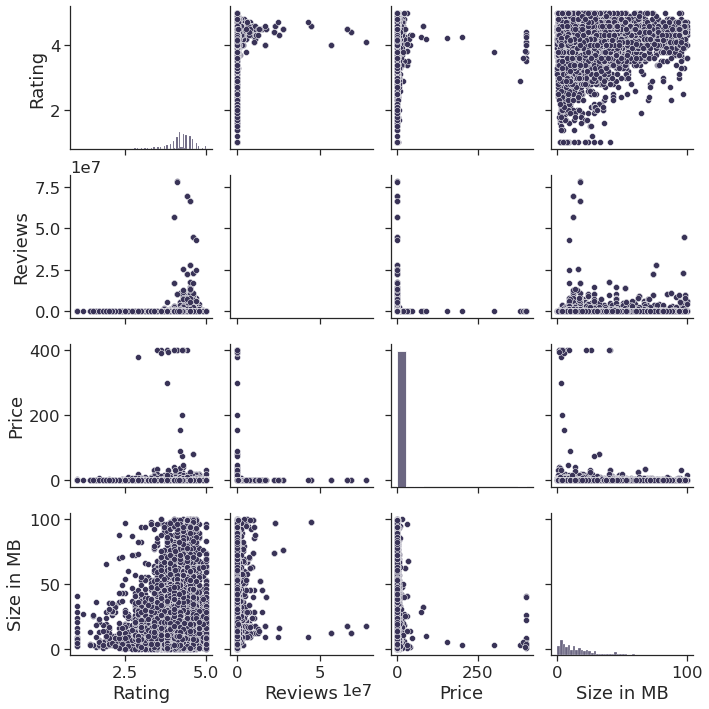

In [85]:
sns.pairplot(df)

# Automatic EDA

In [86]:
%%time
profile = ProfileReport(df, title="Pandas Profiling Report")

CPU times: user 7.47 ms, sys: 0 ns, total: 7.47 ms
Wall time: 7.31 ms


In [87]:
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Exporting Dataset

## Main Dataset

In [149]:
data.to_csv('googleplaystoreapps_cleaned.csv', index=False)

In [148]:
data.head()

App_ID                                                App        Category  \
0       0     Photo Editor & Candy Camera & Grid & Scrapbook  ART_AND_DESIGN   
2       1                                Coloring Book Moana          FAMILY   
3       2  U Launcher Lite – Free Live Cool Themes, Hide ...  ART_AND_DESIGN   
4       3                              Sketch - Draw & Paint  ART_AND_DESIGN   
5       4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN   

   Rating  Reviews     Installs  Type  Price Content Rating  \
0     4.1      159      10,000+  Free    0.0       Everyone   
2     3.9      974     500,000+  Free    0.0       Everyone   
3     4.7    87510   5,000,000+  Free    0.0       Everyone   
4     4.5   215644  50,000,000+  Free    0.0           Teen   
5     4.3      967     100,000+  Free    0.0       Everyone   

                      Genres Last Updated    Genre Main     Genre Sub  \
0               Art & Design   2018-01-07  Art & Design          None   
2  Art & Design;Pretend Play   2018-01-15  Art & Design  Pretend Play   
3               Art & Design   2018-08-01  Art & Design          None   
4               Art & Design   2018-06-08  Art & Design          None   
5    Art & Design;Creativity   2018-06-20  Art & Design    Creativity   

   Size in MB  Installs_Min  
0        19.0         10000  
2        14.0        500000  
3         8.7       5000000  
4        25.0      50000000  
5         2.8        100000

## Sentiment Dataset

In [196]:
df_g_c.to_csv('pct_sentiment.csv', header=True, index=False, sep=',', mode='w')